In [1]:
# 26afc8cbda4ad0776b66c107318114a4eb9f9514
!wandb login 26afc8cbda4ad0776b66c107318114a4eb9f9514

wandb: Appending key for api.wandb.ai to your netrc file: /home/jumelet/.netrc


In [1]:
from transformers import PreTrainedTokenizer, BertTokenizer
from collections import Counter
import json


def create_tokenizer(
    corpus: str, 
    unk_token: str = '<unk>', 
    pad_token: str = '<pad>', 
    mask_token: str = '<mask>',
    min_freq: int = 1,
):
    vocab = create_vocab(corpus, unk_token=unk_token, pad_token=pad_token, mask_token=mask_token, min_freq=min_freq)
            
    tokenizer = create_tf_tokenizer_from_vocab(vocab, unk_token=unk_token, pad_token=pad_token, mask_token=mask_token)
    
    return tokenizer


def create_vocab(
    corpus: str, 
    unk_token: str = '<unk>', 
    pad_token: str = '<pad>', 
    mask_token: str = '<mask>',
    min_freq: int = 1,
):
    with open(corpus) as f:
        train = f.read().split('\n')

    token_freqs = Counter()

    for sen in train:
        for w in sen.split():
            token_freqs[w] += 1
            
    vocab = {unk_token: 0, pad_token: 1, mask_token: 2}
    
    for w, freq in token_freqs.most_common():
        if freq >= min_freq:
            vocab[w] = len(vocab)

    return vocab


class CustomTokenizer(PreTrainedTokenizer):
    def __len__(self):
        return len(self.vocab)

    @property
    def vocab_size(self):
        return len(self.vocab)
    
    def save_vocabulary(self, *args, **kwargs):
        return BertTokenizer.save_vocabulary(self, *args, **kwargs)
    
    def _tokenize(self, sen: str):
        return sen.split(" ")
    
    def _convert_token_to_id(self, w: str):
        return self.vocab.get(w, self.vocab[self.unk_token])


def create_tf_tokenizer_from_vocab(
    vocab, 
    unk_token: str = '<unk>', 
    pad_token: str = '<pad>',
    mask_token: str = '<mask>',
):
    tokenizer = CustomTokenizer()

    tokenizer.added_tokens_encoder = vocab
    tokenizer.added_tokens_decoder = {idx: w for w, idx in vocab.items()}
    tokenizer.vocab = tokenizer.added_tokens_encoder
    tokenizer.ids_to_tokens = tokenizer.added_tokens_decoder
    
    tokenizer.unk_token = unk_token
    tokenizer.pad_token = pad_token
    tokenizer.mask_token = mask_token

    return tokenizer

In [2]:
import os
from typing import Optional, Tuple

from datasets import DatasetDict, load_dataset
from transformers import PreTrainedTokenizerFast


def tokenize_wrapper(tokenizer):
    def tokenize(element, min_length=0, max_length=128):
        input_ids = [
            item
            for item in tokenizer(element["text"])["input_ids"]
            if max_length > len(item) > min_length
        ]
        return {"input_ids": input_ids}  #, "test": element["text"]}

    return tokenize


def load_data(
    tokenizer: PreTrainedTokenizerFast,
    data_dir: str,
    train_size: Optional[int] = None,
    dev_size: Optional[int] = None,
    test_size: Optional[int] = None,
    train_file: str = 'train.txt',
    dev_file: str = 'dev.txt',
    test_file: str = 'test.txt',
    eval_file: Optional[str] = 'eval.txt',
) -> DatasetDict:
    raw_train = load_dataset("text", data_files=os.path.join(data_dir, train_file))[
        "train"
    ]
    raw_dev = load_dataset("text", data_files=os.path.join(data_dir, dev_file))[
        "train"
    ]
    raw_test = load_dataset("text", data_files=os.path.join(data_dir, test_file))[
        "train"
    ]
    if eval_file is not None:
        raw_eval = load_dataset("text", data_files=os.path.join(data_dir, eval_file))[
            "train"
        ]
    else:
        raw_eval = None

    if train_size is not None:
        raw_train = raw_train.shuffle().select(range(train_size))
    if dev_size is not None:
        raw_dev = raw_dev.shuffle().select(range(dev_size))
    if test_size is not None:
        raw_test = raw_test.shuffle().select(range(test_size))

    dataset_dict = {
        "train": raw_train,
        "valid": raw_dev,
        "test": raw_test,
    }

    if raw_eval is not None:
        dataset_dict["eval"] = raw_eval

    raw_datasets = DatasetDict(dataset_dict)

    tokenized_datasets = raw_datasets.map(
        tokenize_wrapper(tokenizer),
        batched=True,
    )

    return tokenized_datasets

In [3]:
from transformers import AutoConfig, PreTrainedTokenizer, AutoModelForMaskedLM, AutoModelForCausalLM
from typing import *


def initialize_model(
    tokenizer: PreTrainedTokenizer, model_type: str, is_mlm: bool = True, **config
) -> Union[AutoModelForMaskedLM, AutoModelForCausalLM]:
    config = AutoConfig.from_pretrained(
        model_type,
        vocab_size=len(tokenizer.added_tokens_encoder),
        **config,
    )
    
    auto_model = AutoModelForMaskedLM if is_mlm else AutoModelForCausalLM

    model = auto_model.from_config(config)

    return model

In [4]:
from datasets import DatasetDict
from transformers import (
    DataCollatorForLanguageModeling,
    PreTrainedTokenizerFast,
    Trainer,
    TrainingArguments,
)


def initialize_trainer(
    model: AutoModelForMaskedLM,
    tokenizer: PreTrainedTokenizerFast,
    data_collator: DataCollatorForLanguageModeling,
    datasets: DatasetDict,
    model_init = None,
    **config,
):
    args = TrainingArguments(**config)

    # if model_init is not None:
    #     model = None

    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=args,
        data_collator=data_collator,
        train_dataset=datasets["train"],
        eval_dataset=datasets["valid"],
        model_init=model_init
    )

    return trainer

# Main loop

In [ ]:
from transformers import DataCollatorForLanguageModeling
import wandb
import json


with open('lm_training/vocab/added_tokens.json') as f:
    vocab = json.load(f)
tokenizer = create_tf_tokenizer_from_vocab(vocab)

datasets = load_data(tokenizer, 'lm_training/corpora')

is_mlm = False

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=is_mlm)

model = initialize_model(
    tokenizer, 
    'distilgpt2', #'microsoft/deberta-v3-base',  # 'phueb/BabyBERTa-1', 
    num_hidden_layers=8, 
    intermediate_size=256,
    hidden_size=256,
    num_attention_heads=8,
    is_mlm=is_mlm,
)

# model = initialize_model(
#     tokenizer, 
#     'facebook/opt-125m',
#     num_hidden_layers=4, 
#     intermediate_size=256,
#     hidden_size=256,
#     word_embed_proj_dim=256,
#     ffn_dim=256,
#     num_attention_heads=8,
#     max_position_embeddings=32,
#     is_mlm=is_mlm,
# )

# model.transformer.wte.weight = model.lm_head.weight

print('#params', sum(param.numel() for param in model.parameters()))

def ray_hp_space(trial):
    return {
        # "learning_rate": tune.loguniform(1e-5, 1e-3),
        # "per_device_train_batch_size": tune.choice([64, 128]),
        "num_hidden_layers": tune.grid_search([6, 8, 10]),
        "hidden_size": tune.grid_search([128, 256, 512]),
        "num_attention_heads": tune.grid_search([8, 16]),
    }


def model_init(trial):
    return initialize_model(
        tokenizer, 
        'phueb/BabyBERTa-1', 
        num_hidden_layers=trial['num_hidden_layers'], 
        intermediate_size=trial['hidden_size'],
        hidden_size=trial['hidden_size'],
        num_attention_heads=trial['num_attention_heads'],
    )


batch_size = 64
lr = 5e-4

os.environ["WANDB_PROJECT"] = "pcfg-lm"

# run = wandb.init(project="pcfg-lm")  #, run_name=f"bsz_{batch_size}-lr_{lr}")

trainer = initialize_trainer(
    model, 
    # model_init=model_init,
    tokenizer, 
    data_collator, 
    datasets, 
    output_dir='checkpoints', 
    save_steps=10_000, 
    eval_steps=100, 
    logging_steps=100,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=8,
    weight_decay=0.1,
    lr_scheduler_type='reduce_lr_on_plateau',
    warmup_steps=0,
    learning_rate=lr,
    num_train_epochs=1,
    fp16=True,
    max_grad_norm=0.5,
    group_by_length=True,
    auto_find_batch_size=False,
    do_eval=True,
    evaluation_strategy='steps',
    report_to="wandb",
)

In [12]:
trainer.train()
wandb.finish()

# trainer._save_checkpoint(trainer.model, None)

/home/jumelet/.local/lib/python3.9/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Currently logged in as: jumelet. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /scratch-local/jumelet.2886114/ipykernel_2858451/2196387447.py:1 in <module>              │
│                                                                                           │
│ [Errno 2] No such file or directory:                                                      │
│ '/scratch-local/jumelet.2886114/ipykernel_2858451/2196387447.py'                          │
│ /home/jumelet/.local/lib/python3.9/site-packages/transformers/trainer.py:1664 in train    │
│                                                                                           │
│   1661 │   │   inner_training_loop = find_executable_batch_size(                          │
│   1662 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batc │
│   1663 │   │   )                                                                          │
│ ❱ 1664 │   │   return inner_training_loop(                                                │
│   1665 │   │   │   args=args,                                                             │
│   1666 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                         │
│   1667 │   │   │   trial=trial,                                                           │
│                                                                                           │
│ /home/jumelet/.local/lib/python3.9/site-packages/transformers/trainer.py:2019 in          │
│ _inner_training_loop                                                                      │
│                                                                                           │
│   2016 │   │   │   │   │   self.state.epoch = epoch + (step + 1 + steps_skipped) / steps_ │
│   2017 │   │   │   │   │   self.control = self.callback_handler.on_step_end(args, self.st │
│   2018 │   │   │   │   │                                                                  │
│ ❱ 2019 │   │   │   │   │   self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ig │
│   2020 │   │   │   │   else:                                                              │
│   2021 │   │   │   │   │   self.control = self.callback_handler.on_substep_end(args, self │
│   2022                                                                                    │
│                                                                                           │
│ /home/jumelet/.local/lib/python3.9/site-packages/transformers/trainer.py:2280 in          │
│ _maybe_log_save_evaluate                                                                  │
│                                                                                           │
│   2277 │   │   │   tr_loss -= tr_loss                                                     │
│   2278 │   │   │                                                                          │
│   2279 │   │   │   logs["loss"] = round(tr_loss_scalar / (self.state.global_step - self._ │
│ ❱ 2280 │   │   │   logs["learning_rate"] = self._get_learning_rate()                      │
│   2281 │   │   │                                                                          │
│   2282 │   │   │   self._total_loss_scalar += tr_loss_scalar                              │
│   2283 │   │   │   self._globalstep_last_logged = self.state.global_step                  │
│                                                                                           │
│ /home/jumelet/.local/lib/python3.9/site-packages/transformers/trainer_pt_utils.py:854 in  │
│ _get_learning_rate                                                                        │
│                                                                                           │
│    851 │   │   │   else:                                                                  │
│    852 │   │   │   │   raise                      

In [8]:
trainer._save_checkpoint(trainer.model, None)

Saving model checkpoint to checkpoints/checkpoint-14839
Configuration saved in checkpoints/checkpoint-14839/config.json
Configuration saved in checkpoints/checkpoint-14839/generation_config.json
Model weights saved in checkpoints/checkpoint-14839/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-14839/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-14839/special_tokens_map.json
added tokens file saved in checkpoints/checkpoint-14839/added_tokens.json


In [ ]:
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.schedulers import ASHAScheduler


best_trial = trainer.hyperparameter_search(
    direction="minimize",
    backend="ray",
    hp_space=ray_hp_space,
    n_trials=3*3*2,
    # search_alg=BayesOptSearch(metric="objective", mode="min"),
    scheduler=ASHAScheduler(metric="objective", mode="min"),
)

# Evaluate Model Perplexity

In [5]:
from tqdm import *
import numpy as np
import torch


def masked_ppl(model, corpus, mask_token_id=None, skip_tokens=None, batch_size=128, return_hidden=False):
    if skip_tokens is None:
        skip_tokens = set()

    model.eval()

    total_tokens = sum(map(len, corpus))
    max_sen_len = max(map(len, corpus))

    # Set all masked tokens in single tensor.
    all_token_ids = torch.zeros(total_tokens, max_sen_len).cuda().int()
    all_attention_masks = torch.zeros(total_tokens, max_sen_len).cuda().int()
    mask_positions = []
    flat_token_ids = []    

    current_idx = 0

    for input_ids in corpus:
        sen_len = len(input_ids)
        current_slice = slice(current_idx, current_idx+sen_len)
        repeated_input_ids = torch.tensor(input_ids).repeat(sen_len, 1).cuda()
        all_token_ids[current_slice, :sen_len] = repeated_input_ids
        all_token_ids[current_slice, :sen_len].fill_diagonal_(mask_token_id)
        
        all_attention_masks[current_slice, :sen_len] = 1
        
        mask_positions.extend(range(sen_len))
        flat_token_ids.extend(input_ids)

        current_idx += sen_len

    mask_positions = torch.tensor(mask_positions).cuda()
    flat_token_ids = torch.tensor(flat_token_ids).cuda()

    # Create model logits for all masked tokens.
    input_iterator = torch.split(all_token_ids, batch_size)
    attention_iterator = torch.split(all_attention_masks, batch_size)
    mask_positions_iterator = torch.split(mask_positions, batch_size)
    flat_token_ids_iterator = torch.split(flat_token_ids, batch_size)

    iterator = zip(
        input_iterator, 
        attention_iterator, 
        mask_positions_iterator, 
        flat_token_ids_iterator
    )

    all_token_probs = []
    all_hidden_states = {layer_idx: [] for layer_idx in range(model.config.num_hidden_layers+1)}

    for idx, batch in enumerate(tqdm(iterator, total=len(input_iterator))):
        input_ids_batch, attention_mask_batch, mask_positions, flat_tokens = batch
        with torch.no_grad():
            batch_slice = slice(idx*batch_size, (idx+1)*batch_size)
            batch_output = model(
                input_ids=input_ids_batch, 
                attention_mask=attention_mask_batch,
                output_hidden_states=return_hidden,
            )
            batch_logits = batch_output.logits
            batch_probs = batch_logits.log_softmax(-1)

        current_idx = 0

        current_bsz = batch_probs.shape[0]
        
        mask_probs = batch_probs[range(current_bsz), mask_positions]
        token_probs = mask_probs[range(current_bsz), flat_tokens]
        if return_hidden:
            for layer_idx, hidden_states in enumerate(batch_output.hidden_states):
                mask_states = hidden_states[range(current_bsz), mask_positions]
                unk_mask = [token_id.item() not in skip_tokens for token_id in flat_tokens]
                all_hidden_states[layer_idx].append(mask_states[unk_mask])
        
        for prob, token_id in zip(token_probs, flat_tokens):
            if token_id.item() not in skip_tokens:
                all_token_probs.append(prob.item())

    ppl = np.exp(-np.sum(all_token_probs)/len(all_token_probs))
    
    if return_hidden:
        return ppl, all_token_probs, all_hidden_states
    else:
        return ppl, all_token_probs


def causal_ppl(model, corpus, skip_tokens):
    model.eval()
    
    all_token_probs = []
    all_sen_probs = []

    for input_ids_list, sen in tqdm(zip(corpus['input_ids'], corpus['text'])):
        input_ids = torch.tensor(input_ids_list).unsqueeze(0).cuda()
        sen_len = input_ids.shape[-1]
        sen_probs = []

        with torch.no_grad():
            probs = model(input_ids[:, :-1]).logits.log_softmax(-1)[0]
            
        for idx, prob_row in enumerate(probs, start=1):
            token_id = input_ids[0, idx].item()
            
            if token_id not in skip_tokens:
                token_prob = prob_row[token_id].item()
                all_token_probs.append(token_prob)
                sen_probs.append(token_prob)

        all_sen_probs.append(sen_probs)

    ppl = np.exp(-np.mean(all_token_probs))
    
    return ppl, all_token_probs, all_sen_probs

# ppl, all_token_probs = eval_corpus(
#     model,
#     datasets['eval']['input_ids'][:], 
#     tokenizer.mask_token_id, 
#     skip_tokens={tokenizer.unk_token_id},
#     batch_size=128,
# )

# ppl, sum(all_token_probs)

# test ppl:
# 86.72 (500k), 77.94 (1M), 79.87 (1M - 128bsz)

# eval ppl:
#               78.38 (1M) -> 85.19 (for all?)

In [6]:
from collections import defaultdict
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score


def get_model_prob_dict(fn):
    with open(fn) as f:
        lines = f.read().split('\n')

    sen2lm_probs = defaultdict(list)
    cur_sen = None

    for line in lines:
        if len(line) == 0:
            continue
        if not line[-1].isnumeric():
            cur_sen = line
        else:
            sen2lm_probs[cur_sen].append(float(line))

    return sen2lm_probs


def get_pcfg_prob_dict():
    with open('lm_training/eval_sens_probs.txt') as f:
        lines = f.read().split('\n')

    sen2pcfg_probs = defaultdict(list)
    cur_sen = None

    for line in lines:
        if len(line) == 0:
            continue
        if line.startswith('Token:'):
            continue
        elif not line[-1].isnumeric():
            cur_sen = line
        else:
            sen2pcfg_probs[cur_sen].append(float(line))
            
    return sen2pcfg_probs


def store_model_probs(all_token_probs, fn: str):
    lines = []
    cur_idx = 0

    for sen in datasets['eval']['text'][:]:
        lines.append(sen)
        sen_len = len(sen.split(' '))

        for prob in all_token_probs[cur_idx:cur_idx+sen_len]:
            lines.append(str(prob))

        cur_idx += sen_len

    with open(fn, 'w') as f:
        f.write('\n'.join(lines))


def get_probs(sen2lm_probs, sen2pcfg_probs):
    lm_probs = []
    pcfg_probs = []
    all_tokens = []
    
    skip_tokens = {tokenizer.unk_token_id}

    for sen, input_ids in zip(datasets['eval']['text'], datasets['eval']['input_ids']):
        pcfg_sen = sen.replace("<apostrophe>", "'")

        sen_pcfg_probs = sen2pcfg_probs[pcfg_sen]
        sen_lm_probs = sen2lm_probs[sen]

        assert len(sen_pcfg_probs) == len(sen_lm_probs), f"{sen}\n{len(sen_pcfg_probs)},{len(sen_lm_probs)}"

        iterator = zip(input_ids, sen_lm_probs, sen_pcfg_probs)
        for idx, (input_id, lm_prob, pcfg_prob) in enumerate(iterator):
            if input_id not in skip_tokens:
                lm_probs.append(np.exp(lm_prob))
                pcfg_probs.append(pcfg_prob)
                all_tokens.append(f"{idx}__{sen}")


    lm_probs = np.array(lm_probs)
    pcfg_probs = np.array(pcfg_probs)

    lm_probs = np.log(lm_probs)
    pcfg_probs = np.log(pcfg_probs)

    return lm_probs, pcfg_probs, all_tokens


def get_causal_lm_pcfg_probs(pcfg_dict_fn, all_sen_probs, corpus, tokenizer):
    import pickle

    with open(pcfg_dict_fn, "rb") as f:
        pcfg_dict = pickle.load(f)

    pcfg_probs = []
    lm_probs = []

    for sen, pcfg_sen_probs in pcfg_dict.items():
        sen_idx = corpus.index(sen)
        lm_sen_probs = all_sen_probs[sen_idx]

        lm_probs.extend(lm_sen_probs)

        for idx, (w, prob) in enumerate(zip(sen.split(), pcfg_sen_probs)):
            if idx > 0 and w in tokenizer.vocab:
                pcfg_probs.append(-prob)
                
    return pcfg_probs, lm_probs

In [7]:
model_name = "deberta"
final_checkpoint = f"/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-14648"
# final_checkpoint = f"/home/jumelet/train_pcfg_lm/checkpoints/model_sizes15_20/20_layers/checkpoint-14839"
# final_checkpoint = f"/home/jumelet/train_pcfg_lm/checkpoints/model_sizes20_512/20_layers/checkpoint-14839"

is_mlm = True
auto_model = AutoModelForMaskedLM if is_mlm else AutoModelForCausalLM
model = auto_model.from_pretrained(final_checkpoint).cuda()

with open(f'{final_checkpoint}/added_tokens.json') as f:
    vocab = json.load(f)
tokenizer = create_tf_tokenizer_from_vocab(vocab)

if 'datasets' not in locals():
    datasets = load_data(tokenizer, 'lm_training/corpora', train_size=0, dev_size=0, test_size=0)

if is_mlm:
    ppl, all_token_probs, all_hidden_states = masked_ppl(
        model,
        datasets['eval']['input_ids'], 
        mask_token_id=tokenizer.mask_token_id, 
        skip_tokens={},
        batch_size=128,
        return_hidden=True,
    )

    store_model_probs(all_token_probs, f'token_probs_eval_{model_name}.txt')

    bert_prob_dict = get_model_prob_dict(f'token_probs_eval_{model_name}.txt')
    pcfg_prob_dict = get_pcfg_prob_dict()

    lm_probs, pcfg_probs, all_tokens = get_probs(bert_prob_dict, pcfg_prob_dict)
else:
    ppl, _, all_sen_probs = causal_ppl(
        model,
        datasets['eval'][:100], 
        skip_tokens={tokenizer.unk_token_id},
    )
    
    pcfg_probs, lm_probs = get_causal_lm_pcfg_probs(
        "lm_training/earleyx_pcfg_dict.pickle", 
        all_sen_probs, 
        datasets['eval'][:100]['text'],
        tokenizer,
    )

    
print(f"Spearman {spearmanr(lm_probs, pcfg_probs)[0]:.3f}")
print(f"R2 {r2_score(lm_probs, pcfg_probs):.3f}")
print(f"LM-PPL {np.exp(-np.mean(lm_probs)):.1f}")
print(f"PCFG-PPL {np.exp(-np.mean(pcfg_probs)):.1f}")

Found cached dataset text (/home/jumelet/.cache/huggingface/datasets/text/default-16c3c054f71c3c4d/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset text (/home/jumelet/.cache/huggingface/datasets/text/default-4f374b48dcc77848/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset text (/home/jumelet/.cache/huggingface/datasets/text/default-b60775d54a08818d/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset text (/home/jumelet/.cache/huggingface/datasets/text/default-179d95133dbc376e/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jumelet/.cache/huggingface/datasets/text/default-179d95133dbc376e/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2/cache-1185ba64778d5722.arrow
100%|██████████| 915/915 [00:29<00:00, 31.37it/s]


Spearman 0.970
R2 0.930
LM-PPL 71.1
PCFG-PPL 63.9


In [14]:
torch.concat(all_hidden_states[0]).shape

torch.Size([117111, 256])

In [27]:
np.mean(lm_probs - pcfg_probs)

-0.10732233574227418

In [15]:
np.argmax(lm_probs - pcfg_probs)

109825

In [12]:
import nltk

with open('lm_training/corpora/eval_trees_10k.txt') as f:
    tree_corpus = [nltk.Tree.fromstring(l.strip()) for l in f]


pos_labels, pos_vocab = create_pos_labels(tree_corpus, skip_unk_tokens=True)


In [13]:
punctuation = "punctuation"
noun= "nouns"
verb = "verbs"
pronoun = "pronouns"
function = "function words"
adjective = "adjectives"
adverb = "adverbs"

pos_map = {
    'APOSTROPHE': punctuation,
    'COLON': punctuation,
    'COMMA': punctuation,
    'CC': function,
    'CD': adjective,
    'DT': function,
    'DOT': punctuation,
    'EX': function,
    'FW': function,
    'HASH': punctuation,
    'IN': function,
    'JJ': adjective,
    'JJR': adjective,
    'JJS': adjective,
    'LRB': punctuation,
    'MD': verb,
    'NN': noun,
    'NNS': noun,
    'NNP': noun,
    'NNPS': noun,
    'PRP': pronoun,
    'PRPDOLLAR': pronoun,
    'PDT': function,
    'POS': function,
    'RBR': adverb,
    'RB': adverb,
    'RP': function,
    'RBS': adverb,
    'RRB': punctuation,
    'SYM': function,
    'TO': function,
    'TICK': punctuation,
    'UH': function,
    'VB': verb,
    'VBD': verb,
    'VBN': verb,
    'VBG': verb,
    'VBP': verb,
    'VBZ': verb,
    'WRB': adverb,
    'WP': pronoun,
    'WDT': function,
    'WPDOLLAR': pronoun,
}

In [51]:
lm_probs.shape, pos_labels.shape

((115960,), torch.Size([115960]))

{'adjectives': -0.22529870656927975, 'function words': -0.20999494802540813, 'adverbs': -0.1783828940623779, 'verbs': -0.09219335892639106, 'nouns': -0.08313068116255025, 'punctuation': -0.03835967996560524, 'pronouns': 0.02304747573767549}


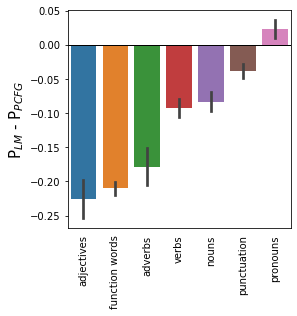

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def create_pos_to_diff_df(lm_probs, pcfg_probs):
    pos_to_diff = defaultdict(list)
    idx2pos = list(pos_vocab.keys())

    for label, diff in zip(pos_labels, lm_probs-pcfg_probs):
        postag = idx2pos[label.item()]

        pos_to_diff[pos_map[postag]].append(diff)

    rows = []
    for pos, diffs in pos_to_diff.items():
        for diff in diffs:
            rows.append((pos, diff))

    df = pd.DataFrame(rows, columns=["pos", "diff"])
    
    return df


df = create_pos_to_diff_df(lm_probs, pcfg_probs)

plt.rcParams["lines.solid_capstyle"] = 'projecting'
plt.figure(figsize=(4,4))

result = df.groupby(["pos"])['diff'].aggregate(np.mean).reset_index().sort_values('diff')
print(dict(zip(result['pos'], result['diff'])))
barplot = sns.barplot(df, x='pos', y='diff', order=result['pos'], estimator=np.mean)

plt.xlabel("")
plt.ylabel("P$_{LM}$ - P$_{PCFG}$", fontsize=15)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,
    top=False,
    rotation=90,
)

plt.axhline(0, lw=1, color='black')

In [22]:
yerr = []
for line in barplot.lines:
    x, y = line.get_xydata()[:,1]
    
    yerr.append(y-x)
    
yerr[:-1]

[0.056003466316347034,
 0.019125523971544572,
 0.05364734146595029,
 0.025447287570316293,
 0.027501345089889384,
 0.019810824297948747,
 0.02556631579797107]

In [18]:
checkpoints = glob(f"/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/*")
sorted_checkpoints = sorted(checkpoints, key=lambda f: int(f.split('-')[-1]))
   
mean_results = []
median_results = []

for checkpoint in sorted_checkpoints:
    print(checkpoint)
    model = AutoModelForMaskedLM.from_pretrained(checkpoint).cuda()

    ppl, all_token_probs, all_hidden_states = masked_ppl(
        model,
        datasets['eval']['input_ids'], 
        mask_token_id=tokenizer.mask_token_id, 
        skip_tokens={},
        batch_size=1024,
        return_hidden=True,
    )

    store_model_probs(all_token_probs, f'token_probs_eval_{model_name}.txt')

    bert_prob_dict = get_model_prob_dict(f'token_probs_eval_{model_name}.txt')
    pcfg_prob_dict = get_pcfg_prob_dict()

    lm_probs, pcfg_probs, all_tokens = get_probs(bert_prob_dict, pcfg_prob_dict)
    
    df = create_pos_to_diff_df(lm_probs, pcfg_probs)
    mean_result = df.groupby(["pos"])['diff'].aggregate(np.mean).reset_index().sort_values('diff')
    median_result = df.groupby(["pos"])['diff'].aggregate(np.median).reset_index().sort_values('diff')
    
    mean_results.append(mean_result)
    median_results.append(median_result)

/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-1000


100%|██████████| 115/115 [00:20<00:00,  5.67it/s]


/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-2000


100%|██████████| 115/115 [00:19<00:00,  5.85it/s]


/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-3000


100%|██████████| 115/115 [00:19<00:00,  5.82it/s]


/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-4000


100%|██████████| 115/115 [00:19<00:00,  5.76it/s]


/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-5000


100%|██████████| 115/115 [00:19<00:00,  5.76it/s]


/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-6000


100%|██████████| 115/115 [00:19<00:00,  5.85it/s]


/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-7000


100%|██████████| 115/115 [00:19<00:00,  5.83it/s]


/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-8000


100%|██████████| 115/115 [00:19<00:00,  5.76it/s]


/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-9000


100%|██████████| 115/115 [00:19<00:00,  5.83it/s]


/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-10000


100%|██████████| 115/115 [00:19<00:00,  5.82it/s]


/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-11000


100%|██████████| 115/115 [00:19<00:00,  5.76it/s]


/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-12000


100%|██████████| 115/115 [00:19<00:00,  5.77it/s]


/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-13000


100%|██████████| 115/115 [00:19<00:00,  5.82it/s]


/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-14000


100%|██████████| 115/115 [00:19<00:00,  5.83it/s]


/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-14648


100%|██████████| 115/115 [00:19<00:00,  5.77it/s]


In [144]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

palette = sns.color_palette('Paired', n_colors=20)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", palette)


plt.rcParams["lines.solid_capstyle"] = 'projecting'

sns.set_theme(style='whitegrid', font_scale=1.2, palette='tab10')
plt.rcParams["lines.solid_capstyle"] = 'projecting'
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rc('hatch', color='1.0', linewidth=.5)
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

plt.rcParams['font.family'] = 'Helvetica'

4          pronouns
5       punctuation
3             nouns
6             verbs
1           adverbs
2    function words
0        adjectives
Name: pos, dtype: object

'pronouns': [-0.07624575992832905, -0.000151825619981949, -0.0004681342251545706, 0.034936274894049046, 0.007707875320084545, 0.06689622721119792, 0.07173640100535583, 0.08943605477731464, 0.06851384672283034, 0.13199145200127516, 0.10583492155224039, 0.10637807648510866, 0.09941854938372241, 0.10631147137836383, 0.10692777289960576] ,
'punctuation': [0.09874650800152678, 0.0994382789355289, 0.07970895478944387, 0.09708746492975548, 0.1051611126040702, 0.10800183669390834, 0.10510602152636897, 0.10244444431340938, 0.09354114256651122, 0.10122152712764373, 0.1019415977079991, 0.10491603595841195, 0.10528313313038068, 0.10380621887558032, 0.10403131356740988] ,
'nouns': [-0.44357799469303894, -0.2666577119445659, -0.22286176597406637, -0.23485675324662836, -0.1866366344740893, -0.14333458141114797, -0.1290769413697257, -0.1149544913994145, -0.08362363826078623, -0.058857203168734884, -0.05375976214280298, -0.042798940289993315, -0.028453517207760903, -0.03383616558596625, -0.032077452137

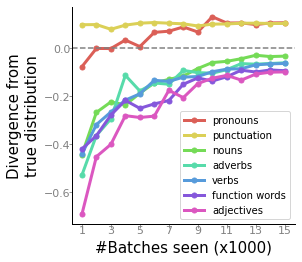

In [19]:
plt.figure(figsize=(4,4))
ax = plt.gca()

results_per_pos = defaultdict(list)

for checkpoint_result in median_results:
    checkpoint_dict = dict(zip(checkpoint_result['pos'], checkpoint_result['diff']))
    for pos in median_results[-1]['pos']:
        results_per_pos[pos].append(checkpoint_dict[pos])

palette = sns.color_palette('hls', len(results_per_pos))

for idx, (pos, diffs) in enumerate(list(results_per_pos.items())[::-1]):
    print(f"'{pos}':", diffs, ',')
    plt.plot(diffs, 'o-', label=pos, lw=3, markersize=5, c=palette[idx])
    
plt.axhline(0, ls='--', c='0.5')
plt.legend(fontsize=10)

plt.grid(False)

plt.xticks(range(0, 15, 2), range(1,16, 2))
plt.xlabel("#Batches seen (x1000)", fontsize=15)
plt.ylabel("Divergence from\ntrue distribution", fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.spines.values(), color="black", lw=1)

ax.tick_params(axis='both', which='major', pad=-2, colors='0.5', labelsize=11)

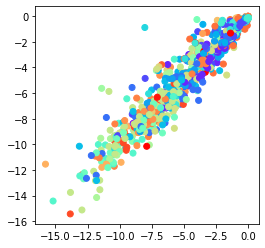

In [54]:
plt.figure(figsize=(4,4))

plt.scatter(lm_probs[:1000], pcfg_probs[:1000], c=pos_labels[:1000], cmap="rainbow", alpha=1)

In [32]:
idx, sen = all_tokens[109825].split('__')

print(sen)
print(sen.split()[int(idx)])

he <apostrophe>s the good access turn more , she could not try to go , and once .
once


(-2.5, 2.5)

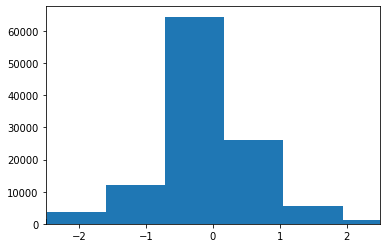

In [26]:
import matplotlib.pyplot as plt


plt.hist(lm_probs - pcfg_probs, bins=20)
plt.xlim(-2.5,2.5)

In [46]:
len(all_hidden_states[8])

915

In [61]:
# all_layer_states = create_states(
#     tokenizer, tree_corpus, model, concat=True, skip_cls=False, verbose=True, all_layers=True
# )
# states = all_layer_states[1]

states = torch.concat(all_hidden_states[8])

dc, test_mcc = train_dc(
    tree_corpus,
    states,
    rank=None, 
    train_epochs=5, 
    verbose=True, 
    separate_tokens=False,
    train_ids=None,
    dev_ids=None,
    test_ids=None,
    skip_unk_tokens=True,
)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.0973       0.0949        3.0769  1.6584
      2        3.0607       0.0950        3.0771  1.6552


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /scratch-local/jumelet.2962959/ipykernel_2285133/2003607537.py:8 in <module>              │
│                                                                                           │
│ [Errno 2] No such file or directory:                                                      │
│ '/scratch-local/jumelet.2962959/ipykernel_2285133/2003607537.py'                          │
│ /scratch-local/jumelet.2962959/ipykernel_2285133/3689675382.py:160 in train_dc            │
│                                                                                           │
│ [Errno 2] No such file or directory:                                                      │
│ '/scratch-local/jumelet.2962959/ipykernel_2285133/3689675382.py'                          │
│                                                                                           │
│ /scratch-local/jumelet.2962959/ipykernel_2285133/3689675382.py:66 in evaluate             │
│                                                                                           │
│ [Errno 2] No such file or directory:                                                      │
│ '/scratch-local/jumelet.2962959/ipykernel_2285133/3689675382.py'                          │
│                                                                                           │
│ /home/jumelet/.local/lib/python3.9/site-packages/sklearn/utils/_param_validation.py:192   │
│ in wrapper                                                                                │
│                                                                                           │
│   189 │   │   │   )                                                                       │
│   190 │   │   │                                                                           │
│   191 │   │   │   try:                                                                    │
│ ❱ 192 │   │   │   │   return func(*args, **kwargs)                                        │
│   193 │   │   │   except InvalidParameterError as e:                                      │
│   194 │   │   │   │   # When the function is just a wrapper around an estimator, we allow │
│   195 │   │   │   │   # the function to delegate validation to the estimator, but we repl │
│                                                                                           │
│ /home/jumelet/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:221   │
│ in accuracy_score                                                                         │
│                                                                                           │
│    218 │   """                                                                            │
│    219 │                                                                                  │
│    220 │   # Compute accuracy for each possible representation                            │
│ ❱  221 │   y_type, y_true, y_pred = _check_targets(y_true, y_pred)                        │
│    222 │   check_consistent_length(y_true, y_pred, sample_weight)                         │
│    223 │   if y_type.startswith("multilabel"):                                            │
│    224 │   │   differing_labels = count_nonzero(y_true - y_pred, axis=1)                  │
│                                                                                           │
│ /home/jumelet/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:86 in │
│ _check_targets                                                                            │
│                                                                                           │
│     83 │                                                                                  │
│     84 │   y_pred : array or indicator matrix     

# Num Params


In [4]:
checkpoints = {
    "bert": f"/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes_bert/7500000_size/checkpoint-14648",
    "roberta": f"/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes_roberta/7500000_size/checkpoint-14648",
    "deberta": f"/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-14648",
    "gpt2": f"/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes_causal/7500000_size/checkpoint-14648",
    "opt": f"/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes_opt/7500000_size/checkpoint-14648",
}

for modelname, checkpoint in checkpoints.items():
    auto_model = AutoModelForCausalLM if modelname in ['gpt2', 'opt'] else AutoModelForMaskedLM

    model = auto_model.from_pretrained(checkpoint).cuda()
    
    nparams = sum(p.numel() for p in model.parameters())
    
    print(modelname, nparams)

bert 9512305
roberta 9512561
deberta 10691441
gpt2 12704512
opt 34012928


In [8]:
print(sum(p.numel() for p in model.lm_head.parameters()))

model

18371328


OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(23921, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 256)
      (project_out): Linear(in_features=256, out_features=768, bias=False)
      (project_in): Linear(in_features=768, out_features=256, bias=False)
      (final_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-7): 8 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=256, out_features=256, bias=True)
            (v_proj): Linear(in_features=256, out_features=256, bias=True)
            (q_proj): Linear(in_features=256, out_features=256, bias=True)
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=256, out_

## Eval Corpus Sizes

In [14]:
from glob import glob
import json
from collections import defaultdict


corpus_sizes = [10_000, 50_000, 100_000, 500_000, 1_000_000, 5_000_000, 7_500_000]
seeds = ["corpus_sizes_causal"] # ["corpus_sizes", "corpus_sizes2", "corpus_sizes3"]

datasets = None

ppls = defaultdict(list)

eval_fn = causal_ppl
auto_model = AutoModelForCausalLM

for seed in seeds:
    for corpus_size in corpus_sizes:
        checkpoints = glob(f"/home/jumelet/train_pcfg_lm/checkpoints/{seed}/{corpus_size}_size/*")
        final_checkpoint = sorted(checkpoints, key=lambda f: int(f.split('-')[-1]))[-1]

        model = auto_model.from_pretrained(final_checkpoint).cuda()

        with open(f'{final_checkpoint}/added_tokens.json') as f:
            vocab = json.load(f)
        tokenizer = create_tf_tokenizer_from_vocab(vocab)

        if datasets is None:
            datasets = load_data(tokenizer, 'lm_training/corpora', train_size=0, dev_size=0, test_size=0)

        ppl, all_token_probs = eval_fn(
            model,
            datasets['eval']['input_ids'], 
            mask_token_id=tokenizer.mask_token_id, 
            skip_tokens={tokenizer.unk_token_id},
            batch_size=128,
        )
        ppls[seed].append(ppl)
        print(corpus_size, ppl)

Found cached dataset text (/home/jumelet/.cache/huggingface/datasets/text/default-16c3c054f71c3c4d/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset text (/home/jumelet/.cache/huggingface/datasets/text/default-4f374b48dcc77848/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset text (/home/jumelet/.cache/huggingface/datasets/text/default-b60775d54a08818d/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset text (/home/jumelet/.cache/huggingface/datasets/text/default-179d95133dbc376e/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jumelet/.cache/huggingface/datasets/text/default-179d95133dbc376e/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2/cache-1185ba64778d5722.arrow
100%|██████████| 10000/10000 [00:55<00:00, 179.55it/s]


10000 689.4168767942786


100%|██████████| 10000/10000 [00:54<00:00, 182.19it/s]


50000 368.5242303842697


100%|██████████| 10000/10000 [00:54<00:00, 182.33it/s]


100000 301.4738534262417


100%|██████████| 10000/10000 [00:55<00:00, 181.77it/s]


500000 204.72539303616804


100%|██████████| 10000/10000 [00:54<00:00, 182.15it/s]


1000000 195.47440889690478


100%|██████████| 10000/10000 [00:55<00:00, 181.81it/s]


5000000 190.89499043555816


100%|██████████| 10000/10000 [00:54<00:00, 182.05it/s]

7500000 190.1178393611341


In [15]:
print(ppls)

defaultdict(<class 'list'>, {'corpus_sizes_causal': [689.4168767942786, 368.5242303842697, 301.4738534262417, 204.72539303616804, 195.47440889690478, 190.89499043555816, 190.1178393611341]})


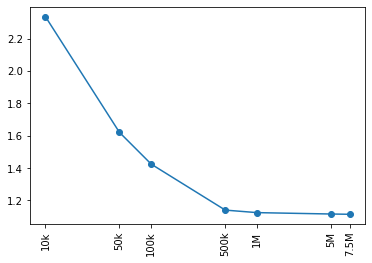

In [24]:
import matplotlib.pyplot as plt


mean_ppl = np.mean([ppl[1:] for ppl in ppls.values()], axis=0)/63.86

plt.plot(corpus_sizes[1:], mean_ppl, 'o-')
# plt.axhline(63.86, ls='--', c='0.5')
plt.xscale('log', base=2)
plt.xticks(corpus_sizes[1:], ['1k', '10k', '50k', '100k', '500k', '1M', '5M', '7.5M'][1:], rotation=90)
plt.show()

In [52]:
!ls /home/jumelet/train_pcfg_lm/checkpoints/model_sizes/

10_layers  2_layers  4_layers  6_layers  8_layers  checkpoint-2
1_layers   3_layers  5_layers  7_layers  9_layers


In [10]:
from glob import glob
import json


model_sizes = range(20,21)
seed = "model_sizes20_512"
datasets = None

ppls = []

for model_size in model_sizes:
    print(model_size)
    size_ppls = []
    
    checkpoints = glob(f"/home/jumelet/train_pcfg_lm/checkpoints/{seed}/{model_size}_layers/*")
    final_checkpoint = sorted(checkpoints, key=lambda f: int(f.split('-')[-1]))[-1]

    with open(f'{final_checkpoint}/added_tokens.json') as f:
        vocab = json.load(f)
    tokenizer = create_tf_tokenizer_from_vocab(vocab)   

    if datasets is None:
        datasets = load_data(tokenizer, 'lm_training/corpora', train_size=0, dev_size=0, test_size=0)
    
    for checkpoint in sorted(checkpoints, key=lambda f: int(f.split('-')[-1])):   
        model = AutoModelForMaskedLM.from_pretrained(checkpoint).cuda()

        ppl, all_token_probs = masked_ppl(
            model,
            datasets['eval']['input_ids'], 
            tokenizer.mask_token_id, 
            skip_tokens={tokenizer.unk_token_id},
            batch_size=1024,
        )
        size_ppls.append(ppl)
    
    ppls.append(size_ppls)

20


Found cached dataset text (/home/jumelet/.cache/huggingface/datasets/text/default-16c3c054f71c3c4d/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset text (/home/jumelet/.cache/huggingface/datasets/text/default-4f374b48dcc77848/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset text (/home/jumelet/.cache/huggingface/datasets/text/default-b60775d54a08818d/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset text (/home/jumelet/.cache/huggingface/datasets/text/default-179d95133dbc376e/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jumelet/.cache/huggingface/datasets/text/default-179d95133dbc376e/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2/cache-1185ba64778d5722.arrow
100%|██████████| 115/115 [00:27<00:00,  4.25it/s]


In [11]:
ppls

[[106.37616636329597,
  92.79321328274175,
  86.83778235653904,
  82.75881374206537,
  80.57135768418729,
  78.7794853017367,
  76.43326762933016,
  74.71877828207225,
  73.23307475655001,
  71.6305699945959,
  70.51389364051131,
  69.76254286186116,
  69.16164973864572,
  68.89090726194864,
  68.86135617468447]]

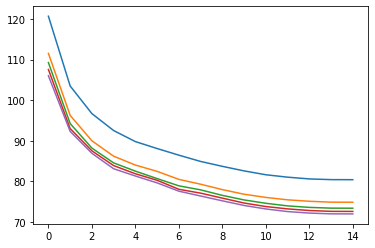

In [61]:
for layer_ppls in ppls:
    plt.plot(layer_ppls[1:])

In [ ]:
checkpoint = 'distilgpt2_1M_64bsz'

automodel = AutoModelForCausalLM  #AutoModelForMaskedLM
model = automodel.from_pretrained(f'checkpoints/{checkpoint}/')

with open(f'checkpoints/{checkpoint}/added_tokens.json') as f:
    vocab = json.load(f)

tokenizer = create_tf_tokenizer_from_vocab(vocab)

datasets = load_data(tokenizer, 'corpora', train_size=1000, dev_size=1000, test_size=1000)


In [60]:
sen = 'It saluted and heard the magnificent cripple throughout the ointment .'
senlist = sen.split()
input_ids_list = tokenizer(sen)['input_ids']

input_ids = torch.tensor(input_ids_list).cuda().unsqueeze(0)
sen_len = input_ids.shape[-1]

with torch.no_grad():
    probs = model(input_ids[:, :-1]).logits.log_softmax(-1)[0]

sen_probs = probs[range(sen_len-1), input_ids[0,1:]].tolist()

list(zip(senlist[1:], sen_probs))

[('saluted', -10.378263473510742),
 ('and', -2.4494380950927734),
 ('heard', -5.718581676483154),
 ('the', -1.7566369771957397),
 ('magnificent', -9.653036117553711),
 ('cripple', -11.647880554199219),
 ('throughout', -8.752653121948242),
 ('the', -1.0396440029144287),
 ('ointment', -10.204730987548828),
 ('.', -0.284556120634079)]

In [ ]:
from transformers import AutoModelForMaskedLM 
import json

model = AutoModelForMaskedLM.from_pretrained('checkpoints/checkpoint-5565').cuda()

with open('lm_training/vocab/added_tokens.json') as f:
    vocab = json.load(f)
tokenizer = create_tf_tokenizer_from_vocab(vocab)

datasets = load_data(tokenizer, 'lm_training/corpora', train_file='train_1.0-1M.txt')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-b973c1704e701dd2/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-61f15a5a423dffb0/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-6f03187f1313a9c4/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-b400bd81a56d38f6/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/950000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
all_token_probs

[-2.3679885864257812,
 -3.134817123413086,
 -4.11724853515625,
 -3.483696937561035,
 -15.15693187713623,
 -8.60286808013916,
 -2.989938497543335,
 -1.4314274787902832,
 -5.957318305969238,
 -0.013733774423599243,
 -0.8044101595878601,
 -6.343593597412109,
 -1.524784803390503,
 -4.152069568634033,
 -4.8558573722839355,
 -10.5933837890625,
 -0.010123927146196365]

In [ ]:
import torch

def get_prob(sen, idx):
    input_ids = tokenizer(sen, return_tensors='pt')['input_ids'].cuda()
    orig_token = input_ids[0,idx].item()
    input_ids[0,idx] = tokenizer.mask_token_id

    with torch.no_grad():
        return model(input_ids).logits.log_softmax(-1)[0,idx,orig_token].item()


sen = 'Michel had such a scaffold throughout Let <apostrophe>s uniform and this did n<apostrophe>t notice .'
# sen = datasets['eval']['text'][1]
print(sen)

for idx, (w) in enumerate(sen.split()):
    print(f'{idx:<3}{w:<15}{get_prob(sen, idx):.5f}')

Michel had such a scaffold throughout Let <apostrophe>s uniform and this did n<apostrophe>t notice .
0  Michel         -9.20433
1  had            -2.74224
2  such           -6.49596
3  a              -1.36655
4  scaffold       -12.45021
5  throughout     -8.45644
6  Let            -4.97617
7  <apostrophe>s  -0.08896
8  uniform        -7.67401
9  and            -1.19508
10 this           -4.95362
11 did            -1.36215
12 n<apostrophe>t -0.36551
13 notice         -6.40777
14 .              -0.01299


In [ ]:
lines = []
cur_idx = 0

for sen in datasets['eval']['text'][:]:
    lines.append(sen)
    sen_len = len(sen.split(' '))

    for prob in all_token_probs[cur_idx:cur_idx+sen_len]:
        lines.append(str(prob))

    cur_idx += sen_len

with open('token_probs_eval.txt', 'w') as f:
    f.write('\n'.join(lines))

In [ ]:
corpus = datasets['test']['input_ids'][:2]

total_tokens = sum(map(len, corpus))
max_sen_len = max(map(len, corpus))

# Set all masked tokens in single tensor.
all_token_ids = torch.zeros(total_tokens, max_sen_len).cuda().int()
all_attention_masks = torch.zeros(total_tokens, max_sen_len).cuda().int()

current_idx = 0

for input_ids in corpus:
    sen_len = len(input_ids)
    current_slice = slice(current_idx, current_idx+sen_len)
    repeated_input_ids = torch.tensor(input_ids).repeat(sen_len, 1).cuda()
    all_token_ids[current_slice, :sen_len] = repeated_input_ids
    all_token_ids[current_slice, :sen_len].fill_diagonal_(tokenizer.mask_token_id)
    
    all_attention_masks[current_slice, :sen_len] = 1

    current_idx += sen_len

# Create model logits for all masked tokens.
input_iterator = torch.split(all_token_ids, batch_size)
attention_iterator = torch.split(all_attention_masks, batch_size)
all_probs = torch.zeros(total_tokens, max_sen_len, model.config.vocab_size)

for idx, (input_ids, attention_mask) in enumerate(zip(input_iterator, attention_iterator)):
    with torch.no_grad():
        batch_slice = slice(idx*batch_size, (idx+1)*batch_size)
        all_logits = model(
            input_ids=input_ids, 
            attention_mask=attention_mask
        ).logits
        all_probs[batch_slice] = all_logits.log_softmax(-1)

# Fetch probabilities for original token ids.
current_idx = 0
all_token_probs = []
skip_tokens = {tokenizer.unk_token_id}

for input_ids in corpus:
    sen_len = len(input_ids)
    current_slice = slice(current_idx, current_idx+sen_len)
    current_probs = all_probs[current_slice, :sen_len]

    token_pos = []
    filtered_input_ids = []

    for idx, token_id in enumerate(input_ids):
        if token_id not in skip_tokens:
            token_pos.append(idx)
            filtered_input_ids.append(token_id)

    token_probs = current_probs[range(sen_len), range(sen_len)][token_pos, filtered_input_ids]

    all_token_probs.extend(token_probs.tolist())
    current_idx += sen_len

In [ ]:
input = torch.tensor(datasets['test']['input_ids'][:1]).cuda()
token = input[0,-1].item()
input[0,-1] = tokenizer.mask_token_id

with torch.no_grad():
    out = model(input)

out.logits.softmax(-1)[0,-1,token]

tensor(0.9941, device='cuda:0')

# Optimal probs

In [9]:
corpus_size = 7_500_000

checkpoints = glob(f"/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/{corpus_size}_size/*")
final_checkpoint = sorted(checkpoints, key=lambda f: int(f.split('-')[-1]))[-1]

model = AutoModelForMaskedLM.from_pretrained(final_checkpoint).cuda()

with open(f'{final_checkpoint}/added_tokens.json') as f:
    vocab = json.load(f)
tokenizer = create_tf_tokenizer_from_vocab(vocab)


datasets = load_data(tokenizer, 'lm_training/corpora', train_size=0, dev_size=0, test_size=0)
   

ppl, all_token_probs = eval_corpus(
    model,
    datasets['eval']['input_ids'], 
    tokenizer.mask_token_id, 
    skip_tokens={},
    batch_size=256,
)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /scratch-local/jumelet.2962672/ipykernel_1878890/2403394263.py:3 in <module>              │
│                                                                                           │
│ [Errno 2] No such file or directory:                                                      │
│ '/scratch-local/jumelet.2962672/ipykernel_1878890/2403394263.py'                          │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'glob' is not defined

In [30]:
def get_model_prob_dict(all_token_probs):
    sen2lm_probs = defaultdict(list)
    cur_idx = 0

    for sen in datasets['eval']['text']:
        sen_len = len(sen.split())
        
        sen2lm_probs[sen] = all_token_probs[cur_idx:cur_idx+sen_len]
        cur_idx += sen_len

    return sen2lm_probs

deberta_prob_dict = get_model_prob_dict(all_token_probs)

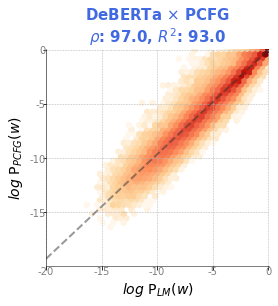

In [31]:
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


def get_probs(sen2lm_probs, sen2pcfg_probs):
    lm_probs = []
    pcfg_probs = []

    first_n = None
    skip_tokens = {tokenizer.unk_token_id}

    for sen, input_ids in zip(datasets['eval']['text'][:first_n], datasets['eval']['input_ids'][:first_n]):
        pcfg_sen = sen.replace("<apostrophe>", "'")

        sen_pcfg_probs = sen2pcfg_probs[pcfg_sen]
        sen_lm_probs = sen2lm_probs[sen]

        assert len(sen_pcfg_probs) == len(sen_lm_probs), f"{sen}\n{len(sen_pcfg_probs)},{len(sen_lm_probs)}"

        for input_id, lm_prob, pcfg_prob in zip(input_ids, sen_lm_probs, sen_pcfg_probs):
            if input_id not in skip_tokens:
                lm_probs.append(np.exp(lm_prob))
                pcfg_probs.append(pcfg_prob)


    lm_probs = np.array(lm_probs)
    pcfg_probs = np.array(pcfg_probs)

    lm_probs = np.log(lm_probs)
    pcfg_probs = np.log(pcfg_probs)

    return lm_probs, pcfg_probs


def plot_probs(lm_probs, pcfg_probs, model_name: str, save_as: Optional[str] = None, cmap = 'OrRd', ymodel='PCFG'):
    fig, ax = plt.subplots(figsize=(4,4))

    # sns.regplot(lm_probs, pcfg_probs, scatter_kws={'alpha':0.05, 's':2}, color='orange', line_kws={"color": "0.5", 'ls': '--', 'lw': 1})
    ax.hexbin(
        lm_probs, 
        pcfg_probs, 
        gridsize=40, 
        mincnt=3,
        cmap=cmap,
        bins='log',
    )

    plt.xlabel(r'$log$ P$_{LM}(w)$', fontsize=14)
    plt.ylabel(r'$log$ P$_{PCFG}(w)$'.replace('PCFG', ymodel), fontsize=14)

    plt.ylim(-20,0.1)
    plt.xlim(-20,0.1)

    # Ticks
    plt.xticks(range(-20,1,5),range(-20,1,5))
    plt.yticks(range(-15,1,5),range(-15,1,5))

    ax.tick_params(
        axis='x', 
        which='major', 
        pad=-3,
        labelcolor="0.5",
    )
    ax.tick_params(
        axis='y', 
        which='major', 
        pad=-3,
        labelcolor="0.5",
    )

    # Grid
    ax.grid(color='0.7', linestyle='--', linewidth=0.5)

    # Spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.setp(ax.spines.values(), color="black", lw=.5)

    # Title
    corr, p = spearmanr(lm_probs, pcfg_probs)
    r2 = r2_score(lm_probs, pcfg_probs) * 100
    
    plt.plot(np.linspace(-20,0,10), pearsonr(lm_probs, pcfg_probs)[0] * np.linspace(-20,0,10), c='0.2', linestyle='--', lw=2, alpha=0.5)
    plt.title(f"{model_name}\n" + f"$\\rho$: {corr*100:.1f}, $R^2$: {r2:.1f}", fontweight=600, color="royalblue", fontsize=15)
        
    if save_as is not None:
        plt.savefig(f"petrov/figures/{save_as}.pdf", bbox_inches="tight")
    
    plt.show()
    
    

deberta_probs, pcfg_probs = get_probs(deberta_prob_dict, pcfg_prob_dict)

plot_probs(deberta_probs, pcfg_probs, "DeBERTa $\\times$ PCFG")

# Span Probing

In [40]:
from transformers import PreTrainedModel
from tqdm import *


def tree_to_spanlabels(tree, merge_pos=False, merge_at=False, skip_labels=None):
    """ Returns the spans of all subtrees and their labels """
    sen_len = len(tree.leaves())
    treeposition_to_span = defaultdict(list)
    treeposition_to_span[()] = [(0, sen_len-1)]

    for i in range(sen_len):
        for j in range(i+2, sen_len):
            treeposition = tree.treeposition_spanning_leaves(i, j)
            span = (i, j - 1) # minus 1 because in self-attention span ends are inclusive
            treeposition_to_span[treeposition].append(span)  

    for treeposition, span in treeposition_to_span.items():
        treeposition_to_span[treeposition] = max(span, key=lambda x: x[1] - x[0])

    nonterminal_treeposition = [
        treeposition
        for treeposition in tree.treepositions()
        if isinstance(tree[treeposition], nltk.Tree)
    ]

    span_ids = torch.zeros(len(treeposition_to_span), 2, device=DEVICE).long()
    labels = []

    for idx, (treeposition, span) in enumerate(treeposition_to_span.items()):
        subtree = tree[treeposition]
        start, end = treeposition_to_span[treeposition]

        span_ids[idx, 0] = start
        span_ids[idx, 1] = end

        label = subtree.label()
        if merge_pos:
            label = label.split("_")[0]
        if merge_at:
            label = label.replace("AT", "")
    
        labels.append(label)
        
    if skip_labels is not None:
        label_mask = [label not in skip_labels for label in labels]
        labels = [label for label, mask in zip(labels, label_mask) if mask]
        span_ids = span_ids[label_mask]

    return span_ids, labels
    

def extract_span_labels(tree_corpus, merge_pos=False, merge_at=False, skip_labels=None):
    all_span_ids = []
    all_labels = []
    
    for tree in tqdm(tree_corpus):
        span_ids, labels = tree_to_spanlabels(
            tree, merge_pos=merge_pos, merge_at=merge_at, skip_labels=skip_labels
        )
        all_span_ids.append(span_ids)
        all_labels.append(labels)
    
    unique_labels = set([label for labels in all_labels for label in labels])
    label_vocab = {
        label: idx
        for idx, label in enumerate(unique_labels)
    }
    all_tokenized_labels = []

    for labels in all_labels:
        tokenized_labels = torch.zeros(len(labels), device=DEVICE).long()
        for idx, label in enumerate(labels):
            tokenized_labels[idx] = label_vocab[label]
        all_tokenized_labels.append(tokenized_labels)
    
    return all_span_ids, all_tokenized_labels, label_vocab


def create_states(
    tokenizer, 
    tree_corpus, 
    model, 
    concat=True, 
    skip_cls=False, 
    num_items=None,
    verbose=False,
    all_layers=False,
    skip_unk_tokens=False,
):
    if isinstance(model, PreTrainedModel):
        all_sens = [torch.tensor(tokenizer.convert_tokens_to_ids(tree.leaves())) for tree in tree_corpus]
        pad_idx = tokenizer.pad_token_id
        num_parameters = model.num_parameters()
    else:
        all_sens = [tokenizer.tokenize(tree.leaves(), pos_tags=tree_to_pos(tree)) for tree in tree_corpus]
        pad_idx = tokenizer.pad_idx
        num_parameters = model.num_parameters

    if num_items is not None:
        all_sens = random.sample(all_sens, num_items)
    lengths = [len(sen) for sen in all_sens]
    sen_tensor = pad_sequence(all_sens, padding_value=pad_idx, batch_first=True).to(DEVICE)

    batch_size = int(1e9 / num_parameters)
    states = defaultdict(list) if all_layers else []
    iterator = range(0, len(all_sens), batch_size)
    if verbose:
        iterator = tqdm(iterator)

    for idx in iterator:
        batch = sen_tensor[idx: idx + batch_size]

        with torch.no_grad():
            all_hidden = model(batch, output_hidden_states=True).hidden_states

        if all_layers:
            for layer_idx, layer_hidden in enumerate(all_hidden):
                for hidden, sen, length in zip(layer_hidden, batch, lengths[idx: idx + batch_size]):
                    unk_mask = sen[:length] != tokenizer.unk_token_id
                    states[layer_idx].append(hidden[:length][unk_mask])
        else:
            states.extend([
                hidden[int(skip_cls):length]
                for hidden, length in zip(all_hidden[-1], lengths[idx: idx + batch_size])
            ])

    if concat:
        if all_layers:
            for layer_idx, layer_states in states.items():
                states[layer_idx] = torch.concat(layer_states)
            return states
        else:
            return torch.concat(states)
    else:
        return states

In [9]:
from sklearn.metrics import f1_score, confusion_matrix
from self_attentive_span_extractor import SelfAttentiveSpanExtractor
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy


class SpanProbe(nn.Module):
    def __init__(self, hidden_size, num_labels, hidden_dropout_prob=0., **kwargs):
        super().__init__()
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.span_attention_extractor = SelfAttentiveSpanExtractor(hidden_size)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, unpooled, spans):
        span_embeddings = self.span_attention_extractor(unpooled, spans)
        span_embeddings = span_embeddings.view(-1, self.hidden_size)
        span_embeddings = self.dropout(span_embeddings)
        logits = self.classifier(span_embeddings)
        return logits


class Config:
    def __init__(self, **kwargs):
        for kwarg, val in kwargs.items():
            setattr(self, kwarg, val)

    def __repr__(self):
        representation = ""
        
        max_len = max(map(len, self.__dict__.keys()))
        for key, value in self.__dict__.items():
            str_value = str(value).split("\n")[0][:20]
            if len(str(value).split("\n")) > 1 or len(str(value).split("\n")[0]) > 20:
                str_value += " [..]"
            representation += (f"{key:<{max_len+3}}{str_value}\n")
            
        return representation
    
    
class ProbeConfig(Config):
    lr: float = 1e-2
    batch_size: int = 48
    epochs: int = 10
    verbose: bool = True
    num_items: Optional[int] = None
    weight_decay: float = 0.1
    

def train_probe(train_data, dev_data, hidden_size, label_vocab, config):
    train_states, train_span_ids, train_labels = train_data
    dev_states, dev_span_ids, dev_labels = dev_data
    train_size = len(train_states)
    
    span_probe = SpanProbe(hidden_size, len(span_label_vocab), hidden_dropout_prob=0.).to(DEVICE)

    optimizer = optim.AdamW(span_probe.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    loss_function = nn.CrossEntropyLoss()

    loss_curve = []
    train_accs = []
    dev_accs = []
    
    best_probe = None
    best_dev_f1 = 0.

    print(f"train f1\tdev f1\t\t--\tmerged f1\tmerged dev f1")
    
    try:
        for epoch in tqdm(range(config.epochs)):
            random_ids = np.array(random.sample(range(train_size), k=train_size))
            batch_size = 48

            batch_iterator = [
                [
                    (train_states[batch_idx], train_span_ids[batch_idx], train_labels[batch_idx])
                    for batch_idx in batch_ids
                ]
                for batch_ids 
                in np.array_split(random_ids, (train_size // config.batch_size - 1))
            ]

            for batch in batch_iterator:
                loss = 0.

                for batch_states, batch_span_ids, batch_labels in batch:
                    pred = span_probe(batch_states.unsqueeze(0), batch_span_ids)
                    loss += loss_function(pred, batch_labels)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(span_probe.parameters(), 0.25)
                optimizer.step()

                loss_curve.append(loss.detach().item())

            train_f1, train_merged_f1, _ = eval_probe(
                span_probe, 
                train_states, 
                train_span_ids, 
                train_labels,
                label_vocab,
            )
            dev_f1, dev_merged_f1, _ = eval_probe(
                span_probe, 
                dev_states, 
                dev_span_ids, 
                dev_labels,
                label_vocab,
            )
            train_accs.append(train_f1)
            dev_accs.append(dev_f1)

            if dev_merged_f1 > best_dev_f1:
                best_dev_f1 = dev_merged_f1
                best_probe = deepcopy(span_probe)

            if config.verbose:
                print(f"{train_f1:.3f} {dev_f1:.3f}\t\t--\t{train_merged_f1:.3f} {dev_merged_f1:.3f}")
    except KeyboardInterrupt:
        print(f"Interrupting training at epoch {epoch}")
        pass

    return best_probe, loss_curve, train_accs, dev_accs


def eval_probe(probe, states, spans, labels, label_vocab):
    probe.eval()
    
    all_labels = []
    all_preds = []
    
    for state, span, label in zip(states, spans, labels):
        with torch.no_grad():
            pred = probe(state.unsqueeze(0), span)
            pred = pred.argmax(-1)
            
            all_labels.extend(label.tolist())
            all_preds.extend(pred.tolist())
    
    probe.train()
    
    f1 = f1_score(all_labels, all_preds, average="micro")
    conf = confusion_matrix(all_labels, all_preds)

    base_labels = set(label.split("_")[0] for label in label_vocab.keys())
    idx_to_label = list(label_vocab.keys())

    correct = 0
    wrong = 0

    for i in range(conf.shape[0]):
        for j in range(conf.shape[1]):
            label_i = idx_to_label[i]
            label_j = idx_to_label[j]

            if label_i.split("_")[0] == label_j.split("_")[0]:
                correct += conf[i,j]
            else:
                wrong += conf[i,j]
    
    return f1, correct / (correct+wrong), (all_labels, all_preds)


def probe_loop(states, span_ids, labels, hidden_size, label_vocab, config):
    corpus_size = len(states)
    train_split, dev_split, test_split = int(0.8 * corpus_size), int(0.9 * corpus_size), corpus_size

    train_states = states[:train_split]
    dev_states = states[train_split:dev_split]
    test_states = states[dev_split:test_split]
    
    train_span_ids = span_ids[:train_split]
    dev_span_ids = span_ids[train_split:dev_split]
    test_span_ids = span_ids[dev_split:test_split]    
    
    train_labels = labels[:train_split]
    dev_labels = labels[train_split:dev_split]
    test_labels = labels[dev_split:test_split]

    span_probe, loss_curve, train_accs, dev_accs = train_probe(
        (train_states, train_span_ids, train_labels),
        (dev_states, dev_span_ids, dev_labels),
        hidden_size,
        label_vocab,
        config,
    )

    test_f1, test_merged_f1, test_preds = eval_probe(
        span_probe, 
        test_states, 
        test_span_ids, 
        test_labels,
        label_vocab,
    )
    
    if config.verbose:
        print((test_f1, test_merged_f1))
    
    return span_probe, loss_curve, train_accs, dev_accs, (test_f1, test_merged_f1), test_preds


In [10]:
from sklearn.linear_model import LogisticRegression


def train_pos_probe(states, labels, train_ratio=0.8):
    num_items = states.shape[0]

    split_idx = int(num_items * train_ratio)
    train_states = states[:split_idx]
    test_states = states[split_idx:]

    train_labels = labels[:split_idx]
    test_labels = labels[split_idx:]
    
    probe = LogisticRegression(verbose=100, solver="lbfgs")
    probe.fit(train_states, train_labels)

    test_preds = torch.tensor(probe.predict(test_states))
    test_acc = (test_preds == test_labels).float().mean()

    print(test_acc)
    
    return probe, (test_labels, test_preds)

# SPAN Probe Training

In [11]:
import nltk
import json
from glob import glob
from collections import defaultdict
import torch
from torch.nn.utils.rnn import pad_sequence

DEVICE = "cuda"

with open('lm_training/corpora/eval_trees_10k.txt') as f:
    tree_corpus = [nltk.Tree.fromstring(l.strip()) for l in f]
    

corpus_size = 7_500_000

checkpoints = glob(f"/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/{corpus_size}_size/*")
final_checkpoint = sorted(checkpoints, key=lambda f: int(f.split('-')[-1]))[-1]

model = AutoModelForMaskedLM.from_pretrained(final_checkpoint).cuda()

with open(f'{final_checkpoint}/added_tokens.json') as f:
    vocab = json.load(f)
tokenizer = create_tf_tokenizer_from_vocab(vocab)


skip_labels = ['WHPP', 'NX', 'WHNP', 'X', 'WHADJP', 'WHADVP', 'RRC', 'NAC', 'CONJP', 'SBARQ']

all_span_ids, all_tokenized_labels, span_label_vocab = extract_span_labels(
    tree_corpus, 
    merge_pos=True,
    merge_at=True,
    skip_labels=skip_labels,
)
all_states = create_states(tokenizer, tree_corpus, model, concat=False, verbose=True, all_layers=True)  

100%|██████████| 108/108 [00:01<00:00, 56.03it/s]


In [12]:
import matplotlib.pyplot as plt

lr = 10e-3
num_epochs = 1

layer_f1 = []

for states in tqdm(all_states.values()):
    hidden_size = states[0].shape[-1]

    probe_config = ProbeConfig(
        lr=lr,
        epochs=num_epochs,
        verbose=True,
        batch_size=48,
    )

    span_probe, loss_curve, train_accs, dev_accs, test_merged_f1, test_preds = probe_loop(
        states, 
        all_span_ids, 
        all_tokenized_labels, 
        hidden_size, 
        span_label_vocab,
        probe_config,
    )
    
    layer_f1.append(test_merged_f1)

  0%|          | 0/9 [00:00<?, ?it/s]

train f1	dev f1		--	merged f1	merged dev f1



100%|██████████| 1/1 [00:14<00:00, 14.59s/it]

0.798 0.796		--	0.798 0.796



 11%|█         | 1/9 [00:15<02:02, 15.26s/it]

(0.7895624472969175, 0.7895624472969175)
train f1	dev f1		--	merged f1	merged dev f1



100%|██████████| 1/1 [00:14<00:00, 14.57s/it]

0.837 0.832		--	0.837 0.832



 22%|██▏       | 2/9 [00:30<01:46, 15.24s/it]

(0.8299447203223086, 0.8299447203223086)
train f1	dev f1		--	merged f1	merged dev f1



100%|██████████| 1/1 [00:14<00:00, 14.55s/it]

0.885 0.883		--	0.885 0.883



 33%|███▎      | 3/9 [00:45<01:31, 15.23s/it]

(0.8780099316031107, 0.8780099316031107)
train f1	dev f1		--	merged f1	merged dev f1



100%|██████████| 1/1 [00:14<00:00, 14.45s/it]

0.903 0.899		--	0.903 0.899



 44%|████▍     | 4/9 [01:00<01:15, 15.18s/it]

(0.8928136419001218, 0.8928136419001218)
train f1	dev f1		--	merged f1	merged dev f1



100%|██████████| 1/1 [00:14<00:00, 14.47s/it]

0.920 0.915		--	0.920 0.915



 56%|█████▌    | 5/9 [01:15<01:00, 15.17s/it]

(0.9068677972453856, 0.9068677972453856)
train f1	dev f1		--	merged f1	merged dev f1



100%|██████████| 1/1 [00:14<00:00, 14.42s/it]

0.923 0.917		--	0.923 0.917



 67%|██████▋   | 6/9 [01:31<00:45, 15.14s/it]

(0.9091164621006278, 0.9091164621006278)
train f1	dev f1		--	merged f1	merged dev f1



100%|██████████| 1/1 [00:14<00:00, 14.46s/it]

0.926 0.922		--	0.926 0.922



 78%|███████▊  | 7/9 [01:46<00:30, 15.13s/it]

(0.9181111215215966, 0.9181111215215966)
train f1	dev f1		--	merged f1	merged dev f1



100%|██████████| 1/1 [00:14<00:00, 14.50s/it]

0.923 0.920		--	0.923 0.920



 89%|████████▉ | 8/9 [02:01<00:15, 15.14s/it]

(0.9120209875386489, 0.9120209875386489)
train f1	dev f1		--	merged f1	merged dev f1



100%|██████████| 1/1 [00:14<00:00, 14.49s/it]

0.919 0.920		--	0.919 0.920



100%|██████████| 9/9 [02:16<00:00, 15.17s/it]

(0.9114588213248384, 0.9114588213248384)


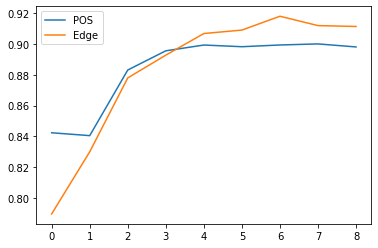

In [21]:
plt.plot(avg_test_mccs[-1], label="POS")

plt.plot([x[0] for x in layer_f1], label="Edge")

plt.legend()

plt.show()



# Train POS Probe

In [11]:
# INIT DIAGNOSTIC CLASSIFIER
from typing import Optional
from skorch import NeuralNetClassifier
import torch
import random

import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from skorch.helper import predefined_split
from skorch.dataset import Dataset
from sklearn import metrics

import nltk
import json
from glob import glob
from collections import defaultdict
from torch.nn.utils.rnn import pad_sequence


DEVICE = "cuda"


def tree_to_pos(tree, skip_unk_tokens=False):
    pos_tags = [
        prod.lhs().symbol().split("_")[0]
        for prod in tree.productions()
        if isinstance(prod.rhs()[0], str)
    ]
    assert len(pos_tags) == len(tree.leaves())
    if skip_unk_tokens:
        no_unk_pos = []
        for pos, w in zip(pos_tags, tree.leaves()):
            if w in tokenizer.vocab:
                no_unk_pos.append(pos)
        return no_unk_pos
    else:
        return pos_tags


def create_pos_labels(tree_corpus, skip_unk_tokens=False):
    pos_labels = []
    
    for tree in tree_corpus:
        pos_labels.extend(tree_to_pos(tree, skip_unk_tokens=skip_unk_tokens))
    
    pos_vocab = {
        pos: idx
        for idx, pos in enumerate(set(pos_labels))
    }
    
    tokenized_pos_labels = [
        pos_vocab[pos]
        for pos in pos_labels
    ]
    
    tokenized_pos_labels = torch.tensor(tokenized_pos_labels, device='cpu')

    return tokenized_pos_labels, pos_vocab


class LogRegModule(nn.Module):
    def __init__(self, ninp: int, nout: int, rank: Optional[int] = None):
        super().__init__()

        if rank is None:
            self.classifier = nn.Linear(ninp, nout)
        else:
            self.classifier = nn.Sequential(
                nn.Linear(ninp, rank), nn.Linear(rank, nout)
            )

    def forward(self, inp: Tensor, create_softmax=True):
        if create_softmax:
            return F.softmax(self.classifier(inp), dim=-1)
        return self.classifier(inp)


def init_classifier(ninp, nout, valid_ds=None, rank=None, epochs=10, verbose=1):
    return NeuralNetClassifier(
        LogRegModule(ninp=ninp, nout=nout, rank=rank),
        lr=0.001,
        max_epochs=epochs,
        optimizer=torch.optim.Adam,
        verbose=verbose,
        train_split=predefined_split(valid_ds)
    )



def fit_dc(X, y, X_dev, y_dev, ninp, nout, train_epochs=10, rank=None, verbose=False):
    valid_ds = Dataset(X_dev, y_dev)
    
    classifier = init_classifier(
        ninp, nout, valid_ds=valid_ds, epochs=train_epochs, rank=rank, verbose=verbose
    )
    classifier.fit(X, y)

    return classifier


def evaluate(X, y, dc):
    y_pred = dc.predict(X)
    acc = metrics.accuracy_score(y, y_pred)
    mcc = metrics.matthews_corrcoef(y, y_pred)

    return acc, mcc


def create_data_split(tree_corpus, tokenizer, skip_unk_tokens=False):
    all_tokens = [w for tree in tree_corpus for w in tree.leaves()]
    if tokenizer is not None:
        all_tokens = [w for w in all_tokens if w in tokenizer.vocab]

    token_pos_dict = defaultdict(list)

    for idx, w in enumerate(all_tokens):
        token_pos_dict[w].append(idx)

    random_order = random.sample(list(token_pos_dict.keys()), k=len(token_pos_dict))

    num_tokens = len(token_pos_dict)
    train_idx, dev_idx, test_idx = int(num_tokens * 0.8), int(num_tokens * 0.9), num_tokens
    train_tokens = random_order[:train_idx]
    dev_tokens = random_order[train_idx:dev_idx]
    test_tokens = random_order[dev_idx:test_idx]

    train_ids = [idx for w in train_tokens for idx in token_pos_dict[w]]
    dev_ids = [idx for w in dev_tokens for idx in token_pos_dict[w]]
    test_ids = [idx for w in test_tokens for idx in token_pos_dict[w]]

    return train_ids, dev_ids, test_ids


def load_model(checkpoint):
    model = AutoModelForMaskedLM.from_pretrained(checkpoint).cuda()

    with open(f'{checkpoint}/added_tokens.json') as f:
        vocab = json.load(f)
    tokenizer = create_tf_tokenizer_from_vocab(vocab)

    return model, tokenizer


def train_dc(
    tree_corpus,
    states,
    rank=None, 
    train_epochs=5, 
    verbose=False, 
    separate_tokens=True,
    train_ids=None,
    dev_ids=None,
    test_ids=None,
    skip_unk_tokens=False,
):
    pos_labels, pos_vocab = create_pos_labels(tree_corpus, skip_unk_tokens=skip_unk_tokens)
    if train_ids is None and separate_tokens:
        train_ids, dev_ids, test_ids = create_data_split(
            tree_corpus, tokenizer, skip_unk_tokens=skip_unk_tokens
        )
    if not separate_tokens:
        total_size = len(states)
        train_idx, dev_idx, test_idx = int(total_size * 0.8), int(total_size * 0.9), total_size
        
        train_ids = range(0, train_idx)
        dev_ids = range(train_idx, dev_idx)
        test_ids = range(dev_idx, test_idx)

    train_x = states[train_ids]
    train_y = pos_labels[train_ids]

    dev_x = states[dev_ids]
    dev_y = pos_labels[dev_ids]

    test_x = states[test_ids]
    test_y = pos_labels[test_ids]        

    print(states.shape, pos_labels.shape)
        
    ninp, nout = train_x.shape[-1], len(pos_vocab)

    dc = fit_dc(
        train_x, 
        train_y, 
        dev_x, 
        dev_y, 
        ninp, 
        nout, 
        rank=rank, 
        train_epochs=train_epochs, 
        verbose=verbose
    )
    print(test_x.shape, test_y.shape)
    test_mcc = evaluate(test_x, test_y, dc)[1]

    if verbose:
        print(f"Test mcc. {test_mcc:.3f}")
    
    return dc, test_mcc, (train_ids, dev_ids, test_ids), (train_x, train_y, dev_x, dev_y, test_x, test_y)

In [31]:
all_layer_states = create_states(
    tokenizer, 
    tree_corpus, 
    model, 
    concat=True, 
    skip_cls=False, 
    verbose=True, 
    all_layers=True, 
    skip_unk_tokens=True,
)
states = all_layer_states[1]

with open('lm_training/corpora/eval_trees_10k.txt') as f:
    tree_corpus = [nltk.Tree.fromstring(l.strip()) for l in f]


ppl, token_probs, all_hidden_states = masked_ppl(
    model,
    datasets['eval']['input_ids'], 
    mask_token_id=tokenizer.mask_token_id, 
    skip_tokens={tokenizer.unk_token_id},
    batch_size=128,
    return_hidden=True,
)

layer_idx = 8
hidden_states = torch.concat(all_hidden_states[layer_idx])
# hidden_states = all_layer_states[layer_idx]
with torch.no_grad():
    states = model.cls.predictions.transform(hidden_states)


dc, test_mcc, ids, data = train_dc(
    tree_corpus,
    states,
    rank=None, 
    train_epochs=5, 
    verbose=True, 
    separate_tokens=False,
    train_ids=None,
    dev_ids=None,
    test_ids=None,
    skip_unk_tokens=True,
)

100%|██████████| 915/915 [00:27<00:00, 32.93it/s]


torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1873       0.6699        1.1101  1.5683
      2        1.0998       0.6689        1.1053  1.5555
      3        1.0932       0.6695        1.1041  1.5391
      4        1.0891       0.6683        1.1038  1.5351
      5        1.0861       0.6688        1.1039  1.5367
torch.Size([11596, 256]) torch.Size([11596])
Test mcc. 0.642


In [32]:
test_x, test_y = data[4], data[5]

pos_preds = np.log(dc.predict_proba(test_x)[range(len(test_y)), test_y])

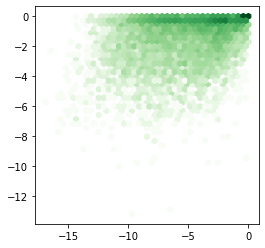

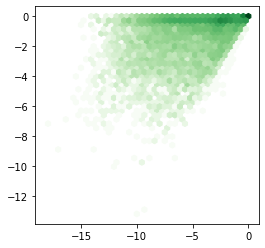

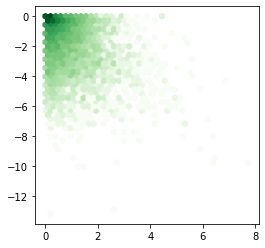

SignificanceResult(statistic=0.5464031497789114, pvalue=0.0)
SignificanceResult(statistic=0.5901461561548503, pvalue=0.0)
SignificanceResult(statistic=-0.5086541644492365, pvalue=0.0)


In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.hexbin(pcfg_probs[ids[2]], pos_preds, mincnt=1, gridsize=40, bins='log',cmap="Greens")
plt.show()

plt.figure(figsize=(4,4))
plt.hexbin(lm_probs[ids[2]], pos_preds, mincnt=1, gridsize=40, bins='log',cmap="Greens")
plt.show()

plt.figure(figsize=(4,4))
plt.hexbin(np.abs(lm_probs[ids[2]] - pcfg_probs[ids[2]]), pos_preds, mincnt=1, gridsize=40, bins='log',cmap="Greens")
# plt.ylim(-4,0)
# plt.xlim(0,4)
plt.show()

print(spearmanr(pcfg_probs[ids[2]], pos_preds))
print(spearmanr(lm_probs[ids[2]], pos_preds))
print(spearmanr(np.abs(lm_probs[ids[2]]-pcfg_probs[ids[2]]), pos_preds))

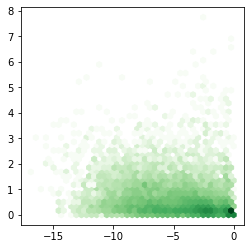

In [39]:
plt.figure(figsize=(4,4))
plt.hexbin(pcfg_probs[ids[2]], np.abs(lm_probs[ids[2]]-pcfg_probs[ids[2]]), mincnt=1, gridsize=40, bins='log',cmap='Greens')

(array([   4.,    6.,    9.,   10.,   13.,   21.,   31.,   32.,   36.,
          60.,   86.,  135.,  167.,  217.,  270.,  380.,  488.,  654.,
         832., 3155.]),
 array([-1.0865794e+01, -1.0322541e+01, -9.7792883e+00, -9.2360363e+00,
        -8.6927834e+00, -8.1495304e+00, -7.6062775e+00, -7.0630250e+00,
        -6.5197721e+00, -5.9765191e+00, -5.4332666e+00, -4.8900137e+00,
        -4.3467607e+00, -3.8035083e+00, -3.2602553e+00, -2.7170026e+00,
        -2.1737499e+00, -1.6304971e+00, -1.0872444e+00, -5.4399163e-01,
        -7.3883403e-04], dtype=float32),
 <BarContainer object of 20 artists>)

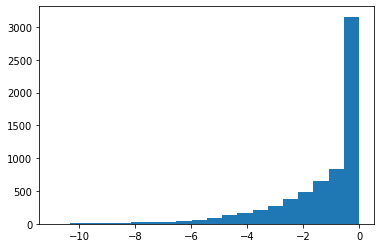

In [166]:
plt.hist(pos_preds, bins=20)

In [125]:
with open('lm_training/corpora/eval_trees_10k.txt') as f:
    tree_corpus = [nltk.Tree.fromstring(l.strip()) for l in f]
    

corpus_size = 7_500_000

checkpoints = glob(f"/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/{corpus_size}_size/*")
final_checkpoint = sorted(checkpoints, key=lambda f: int(f.split('-')[-1]))[-1]

model = AutoModelForMaskedLM.from_pretrained(final_checkpoint).cuda()

with open(f'{final_checkpoint}/added_tokens.json') as f:
    vocab = json.load(f)
tokenizer = create_tf_tokenizer_from_vocab(vocab)


pos_labels, pos_vocab = create_pos_labels(tree_corpus)
states = create_states(tokenizer, tree_corpus, model, concat=True, skip_cls=False, verbose=True, all_layers=True)

100%|██████████| 108/108 [00:01<00:00, 65.59it/s]


In [42]:
with open('lm_training/corpora/eval_trees_10k.txt') as f:
    tree_corpus = [nltk.Tree.fromstring(l.strip()) for l in f]

pos_labels, pos_vocab = create_pos_labels(tree_corpus, skip_unk_tokens=True)
train_ids, dev_ids, test_ids = create_data_split(tree_corpus, tokenizer, skip_unk_tokens=True)

all_test_mccs = []

checkpoints = glob(f"/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/*")
sorted_checkpoints = sorted(checkpoints, key=lambda f: int(f.split('-')[-1]))

for checkpoint in sorted_checkpoints:
    print(checkpoint)
    model, tokenizer = load_model(checkpoint)
    model.eval()

    all_layer_states = create_states(
        tokenizer, 
        tree_corpus, 
        model, 
        concat=True, 
        skip_cls=False, 
        verbose=True, 
        all_layers=True, 
        skip_unk_tokens=True
    )

    test_mccs = []

    for layer_idx, states in tqdm(all_layer_states.items()):
        if layer_idx < 8:
            continue
        with torch.no_grad():
            states = model.cls.predictions.transform(states)
            
        dc, test_mcc, _, _ = train_dc(
            tree_corpus, 
            states, 
            verbose=True, 
            train_epochs=5, 
            train_ids=train_ids,
            dev_ids=dev_ids,
            test_ids=test_ids,
            separate_tokens=True,
            skip_unk_tokens=True,
        )
        test_mccs.append(test_mcc)

    all_test_mccs.append(test_mccs)

/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-1000


  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3149       0.5263        3.7153  1.6234
      2        0.4538       0.5106        4.1787  1.6218
      3        0.3761       0.4262        4.4881  1.6248
      4        0.3520       0.3793        4.5871  1.6202
      5        0.3408       0.3682        4.6094  1.6239


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]

torch.Size([8855, 256]) torch.Size([8855])
Test mcc. 0.648
/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-2000



  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2406       0.5200        4.2404  1.6219
      2        0.3866       0.5279        4.5121  1.6099
      3        0.3154       0.4727        4.6600  1.6088
      4        0.2926       0.4502        4.6851  1.6092
      5        0.2802       0.4281        4.7566  1.6129


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]

torch.Size([8855, 256]) torch.Size([8855])
Test mcc. 0.753
/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-3000



  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1512       0.5375        3.3599  1.6294
      2        0.3436       0.5548        3.6494  1.6256
      3        0.2805       0.5564        3.8152  1.6253
      4        0.2631       0.5689        4.0582  1.6319
      5        0.2525       0.5698        3.8061  1.6312


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]

torch.Size([8855, 256]) torch.Size([8855])
Test mcc. 0.781
/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-4000



  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2139       0.5460        3.3118  1.6328
      2        0.3190       0.5592        3.6005  1.6343
      3        0.2614       0.5671        3.7299  1.6313
      4        0.2492       0.5732        3.7304  1.6245
      5        0.2457       0.5557        3.6560  1.6252


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]

torch.Size([8855, 256]) torch.Size([8855])
Test mcc. 0.823
/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-5000



  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1775       0.5293        4.2282  1.6320
      2        0.3063       0.5248        4.4856  1.6297
      3        0.2520       0.5442        4.4886  1.6411
      4        0.2444       0.5497        4.4285  1.6065
      5        0.2426       0.5368        4.2803  1.6103


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]

torch.Size([8855, 256]) torch.Size([8855])
Test mcc. 0.812
/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-6000



  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1735       0.5425        3.7584  1.6186
      2        0.3032       0.5619        3.6863  1.6115
      3        0.2453       0.5675        3.5768  1.6158
      4        0.2289       0.5827        3.3952  1.6149
      5        0.2353       0.5753        3.3900  1.6131


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]

torch.Size([8855, 256]) torch.Size([8855])
Test mcc. 0.842
/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-7000



  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2259       0.5448        3.4911  1.6239
      2        0.3056       0.5677        3.7070  1.6218
      3        0.2435       0.5734        3.8005  1.6198
      4        0.2250       0.5811        3.8303  1.6153
      5        0.2281       0.5693        3.8266  1.6117


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]

torch.Size([8855, 256]) torch.Size([8855])
Test mcc. 0.853
/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-8000



  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1537       0.5543        3.6109  1.6182
      2        0.2803       0.5719        3.8076  1.6116
      3        0.2229       0.5685        3.8611  1.6083
      4        0.2160       0.5726        3.9979  1.6487
      5        0.2097       0.5639        4.1664  1.6290


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]

torch.Size([8855, 256]) torch.Size([8855])
Test mcc. 0.854
/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-9000



  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1544       0.5529        3.3021  1.9004
      2        0.2755       0.5716        3.8140  1.6456
      3        0.2223       0.5830        4.0805  1.6310
      4        0.2106       0.5915        4.2878  1.6585
      5        0.2106       0.5817        4.3405  1.6439


100%|██████████| 9/9 [00:09<00:00,  1.07s/it]

torch.Size([8855, 256]) torch.Size([8855])
Test mcc. 0.846
/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-10000



  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2509       0.5494        3.7677  1.6334
      2        0.2866       0.5755        4.0239  1.6302
      3        0.2279       0.5812        4.0891  1.6267
      4        0.2136       0.5888        4.1219  1.6437
      5        0.2034       0.5803        4.0006  1.6292


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]

torch.Size([8855, 256]) torch.Size([8855])
Test mcc. 0.854
/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-11000



  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1609       0.5504        3.7877  1.6322
      2        0.2846       0.5725        3.9335  1.6264
      3        0.2235       0.5741        3.8910  1.6254
      4        0.2067       0.5798        3.9377  1.6257
      5        0.1987       0.5747        3.8172  1.6310


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]

torch.Size([8855, 256]) torch.Size([8855])
Test mcc. 0.856
/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-12000



  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1789       0.5447        3.1918  1.6508
      2        0.2844       0.5692        3.5488  1.6292
      3        0.2278       0.5795        3.5880  1.6310
      4        0.2132       0.5825        3.6122  1.6319
      5        0.2008       0.5823        3.5112  1.8978


100%|██████████| 9/9 [00:09<00:00,  1.06s/it]

torch.Size([8855, 256]) torch.Size([8855])
Test mcc. 0.856
/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-13000



  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2306       0.5534        3.7970  1.6355
      2        0.2832       0.5771        4.0201  1.6285
      3        0.2281       0.5764        4.0349  1.6322
      4        0.2119       0.5803        4.0437  1.6286
      5        0.2012       0.5697        4.0437  1.6328


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]

torch.Size([8855, 256]) torch.Size([8855])
Test mcc. 0.853
/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-14000



  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2448       0.5493        4.1157  1.6388
      2        0.2838       0.5764        4.3241  1.6328
      3        0.2262       0.5812        4.2498  1.6345
      4        0.2140       0.5844        4.4234  1.6367
      5        0.2057       0.5749        4.5958  1.6335


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]

torch.Size([8855, 256]) torch.Size([8855])
Test mcc. 0.859
/home/jumelet/train_pcfg_lm/checkpoints/corpus_sizes/7500000_size/checkpoint-14648



  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([115960, 256]) torch.Size([115960])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2246       0.5523        3.3071  1.6301
      2        0.2862       0.5710        3.6303  1.6281
      3        0.2262       0.5823        3.7757  1.6275
      4        0.2131       0.5871        3.8705  1.6458
      5        0.1981       0.5827        3.8538  1.6302


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]

torch.Size([8855, 256]) torch.Size([8855])
Test mcc. 0.846


In [43]:
all_test_mccs

[[0.6481428451339438],
 [0.752746519755018],
 [0.7809877654460622],
 [0.822896626899242],
 [0.8124773369502167],
 [0.8424163412238899],
 [0.852722750261635],
 [0.8541422097698553],
 [0.8463304720982628],
 [0.8539035396087044],
 [0.8556999550148744],
 [0.8558363940216683],
 [0.8525806800138735],
 [0.8592052854309055],
 [0.8462371306274998]]

In [ ]:
(lm_probs-pcfg_probs)[test_ids]

In [142]:
dc_probs = dc.predict_proba(test_x)[range(len(test_x)), test_y]

In [14]:
prev_test_mccs = [[0.7781217339861507,  0.7399300864351005,  0.7619810743491864,  0.7694698792098812,  0.7773937410161368,  0.7728437337974193,  0.7705404427101413,  0.769790493771578,  0.7699527288861484], [0.7738317096761972,  0.7805095715919909,  0.8027333726478112,  0.8346083073743539,  0.8557193470033051,  0.8516467404435349,  0.8106316742448345,  0.848452461345941,  0.815790490609408], [0.7862219750630914,  0.7730160304819742,  0.8207639879258902,  0.8532801042556676,  0.8633353719163489,  0.8577995459448478,  0.8586930746625819,  0.8575600924226989,  0.8564147314224119], [0.7896901897040869,  0.8019269878184204,  0.8198548070266554,  0.850399941978929,  0.8698966322396724,  0.8670869970460876,  0.8677894409033238,  0.863962264377046,  0.8267460599054741], [0.7950647020390645,  0.7967072756306349,  0.8430426633162525,  0.8659472063945614,  0.8728566843615604,  0.86900962783275,  0.8682815564028069,  0.8632791638541439,  0.8622234634735362], [0.8413479001723702,  0.8020496171124895,  0.8531303166845255,  0.869808373551316,  0.8737126291436295,  0.872143478813561,  0.8716939806205735,  0.8706700169706133,  0.8712375359430982], [0.8424212341244592,  0.8028758367137393,  0.850883333083053,  0.8740521056990046,  0.8799538119238693,  0.8770285564021368,  0.8767281812405268,  0.8785274107373587,  0.8744239709794727], [0.7987326898710844,  0.8078869798427452,  0.8617674507088525,  0.8764649792111059,  0.8801427768280355,  0.8780386981062193,  0.8775157149907152,  0.8769545476373313,  0.8730997470036094], [0.800114549030752,  0.8275221066678097,  0.8663759164158247,  0.8792505770918992,  0.8841097096251231,  0.8801342556549949,  0.8766108463867957,  0.8772612083006668,  0.8806452671612116], [0.8005921300757265,  0.8345245921017834,  0.8652826607298705,  0.8774342028311666,  0.8794085176333724,  0.8807258819675553,  0.8784552239247857,  0.8826338994634195,  0.8820845230716399], [0.842063411432168,  0.8102455610700897,  0.86495811737269,  0.8766564180337317,  0.8818208026000413,  0.8819081404118776,  0.8816929722568071,  0.8824536062229413,  0.8814184920518272], [0.801987939538379,  0.81037674500864,  0.862908465456455,  0.8800958462777408,  0.8836089375576919,  0.8862056290288512,  0.884181026758125,  0.884682674832662,  0.8831151268005228], [0.8024874512224227,  0.8121619162327608,  0.8684283487211535,  0.8821208234884841,  0.8835600357278927,  0.8834479430267356,  0.884340960890038,  0.8836945098822868,  0.8846151343169977], [0.800054154709005,  0.8111279143449334,  0.8635763748046905,  0.8796757889708743,  0.8853186688808051,  0.8834194407377375,  0.8835689124960542,  0.8826473988628796,  0.8829853732081486], [0.8437379139235928,  0.8133558152958945,  0.8651848118670539,  0.8801915197729938,  0.8835144725369931,  0.8837985815955279,  0.883410041114421,  0.8820605498264378,  0.8835184621167641]]
prev_test_mccs2 = [[0.7682770683233778,  0.7903715724001127,  0.7958657272032518,  0.8418379310349082,  0.8343140716807467,  0.8298740092707816,  0.8270923833125235,  0.8269698367202577,  0.8296467551606383], [0.783467936132751,  0.7977107603874499,  0.8555578994817719,  0.8628233988738595,  0.8638414869468027,  0.8664996583318108,  0.8681538373329427,  0.8694931441516005,  0.8650810225217296], [0.8193162550259637,  0.8198494597167587,  0.8534577367553645,  0.8748841212227049,  0.8764359993216253,  0.8765459935062277,  0.8799225145273332,  0.8708236641384128,  0.8442760153321707], [0.7999428714802681,  0.8477810594418285,  0.8490765647295259,  0.8586895967300896,  0.865010206005833,  0.8863161077170344,  0.8632097142866129,  0.887014900304858,  0.891770965138599], [0.8000221443670068,  0.8212940475614006,  0.8714829350177324,  0.8859288827148692,  0.8848324270740338,  0.8912817287283549,  0.8914714340176068,  0.8929162834152222,  0.8887503468749515], [0.8078253016798819,  0.8252862329590483,  0.8914536845865024,  0.9073352637977686,  0.8963680934873154,  0.8974693853951089,  0.8971736166226356,  0.8980957084777939,  0.8919935170193075], [0.8112927664548697,  0.8661148110076673,  0.8654097975746272,  0.8992481707278993,  0.9000707808211641,  0.9011721035174183,  0.9015837454564429,  0.9007675531257494,  0.8976953195165566], [0.8421445392254336,  0.8533998599462261,  0.910755073666319,  0.9051549903242565,  0.9068268317570473,  0.903560138872822,  0.9005167979631655,  0.9105932276381598,  0.8971630957102585], [0.8501061332455131,  0.8898432977436143,  0.9064439275293809,  0.9018755877096678,  0.903383084812136,  0.9115512193392378,  0.909635093222844,  0.9160071391330314,  0.9016060260377299], [0.8189438219256552,  0.8611194284615916,  0.8949339863322864,  0.9019309065010234,  0.9063937506776255,  0.9088241209620664,  0.9107806756164846,  0.9033118041520037,  0.9026328128267904], [0.8719807088476856,  0.8839969570748235,  0.9082966528289286,  0.9089270785129943,  0.9143957453023894,  0.9118705732352482,  0.9134803799353085,  0.909194589239948,  0.9073345984511239], [0.8688535710539957,  0.8437934856772628,  0.9016359638024778,  0.912563029554997,  0.9083084522452562,  0.9072704812658189,  0.9100555179637037,  0.9138427386287314,  0.9099668624575582], [0.8687497204297763,  0.8795893704453132,  0.909902422518666,  0.9067440881404699,  0.9123092817148424,  0.910191410776963,  0.9137204772493251,  0.9063895205854305,  0.911363946306826], [0.8167458772085919,  0.8824178539592905,  0.9031160520543271,  0.9148164824620525,  0.9129584024069178,  0.9130881839833188,  0.9093544015160488,  0.9082140722785591,  0.9156810587598547], [0.8703199431776727,  0.8782095738883541,  0.8968924179221611,  0.9100820597466659,  0.9121902274257321,  0.9104644382770397,  0.9134920412712928,  0.913334062619691,  0.9104131367648658]]
prev_test_mccs3 = [[0.6929590364330894,  0.705983085300784,  0.7685801733449628,  0.7830709348783507,  0.8122946227997772,  0.8062880470552837,  0.7864972193512726,  0.813582001116261,  0.8172243408367431], [0.7328497547619187,  0.7141561375498913,  0.7892177934039369,  0.8013594140081202,  0.8367241842034918,  0.8285933547247429,  0.8295290349200132,  0.8430925093593921,  0.8536027201630423], [0.7483257046212813,  0.732307546311126,  0.8149213978754957,  0.8503295562505181,  0.8671774746419377,  0.8605683192765282,  0.8574664054950079,  0.8567690007504947,  0.8350587635615295], [0.7374599504057904,  0.7575984048909136,  0.8347612397447769,  0.8695030096870832,  0.8789623124849022,  0.8787343528361575,  0.8799683205281988,  0.8732548108604559,  0.8741572733955929], [0.7484136537352585,  0.8080039424366705,  0.8597027042832291,  0.8417856947610023,  0.8766121244862011,  0.875834888440551,  0.8810202987478114,  0.8548542281716717,  0.8771758948384796], [0.7822421826596331,  0.8184043252542652,  0.8709409161082723,  0.8834654491760109,  0.882884582085169,  0.8876770329557085,  0.888389159942987,  0.8880866053627057,  0.8880681615006517], [0.7665044356486536,  0.7909150995355655,  0.8824898938709305,  0.889763667513206,  0.8960898135091194,  0.8913277572615441,  0.8915158897589213,  0.8962521228535132,  0.8936909288561391], [0.7711316534680892,  0.7890871770306725,  0.880932634048253,  0.8855683444361896,  0.8945882058363088,  0.8948773213093928,  0.8883730578312417,  0.8929075236555866,  0.8940596749476545], [0.772977470529182,  0.7845886411970581,  0.8839934432486458,  0.8942469135126514,  0.8988772722657128,  0.898456562663529,  0.8954088826385662,  0.9001234746435512,  0.899328744398557], [0.8140338450019136,  0.811105560208945,  0.8815532094380949,  0.8919129250137753,  0.8974279891961794,  0.8971868183030327,  0.9002379640913805,  0.9012872205030126,  0.8979027111563437], [0.8137842530019671,  0.8047365678361301,  0.8834493039305698,  0.8956133314073852,  0.9021124645305474,  0.9005514827779898,  0.8999723011706124,  0.9024334964195851,  0.8969084987442763], [0.8278626448323024,  0.8079932264129596,  0.8735288497060821,  0.8980022953370176,  0.8990861097634645,  0.9012227796495983,  0.9037369434802486,  0.9042320242155049,  0.9031327818689939], [0.8129192731766468,  0.8140399230131488,  0.8841774975420238,  0.8971047888760226,  0.8938407016321097,  0.8989376509995597,  0.9012821718262962,  0.9026723711433032,  0.9021975055754863], [0.8297528318544478,  0.7845757379905133,  0.88463260041273,  0.896186399859738,  0.896868214520064,  0.8986111237582858,  0.9012493498878194,  0.9029034214860286,  0.9025010895791632], [0.8129449106192198,  0.8298441885154632,  0.8873373280794049,  0.8966382737966513,  0.9024665632980472,  0.9006229723828694,  0.9013755181955968,  0.9049572813988226,  0.9005190999776406]]
prev_test_mccs4 = [[0.814851632497883,  0.827369530717667,  0.8591196353349788,  0.8263451441644529,  0.847219999001939,  0.7626581836291914,  0.78116723681304,  0.7790923130668661,  0.7843534453174775], [0.8402988764457293,  0.8171654223985494,  0.8632020471449656,  0.8705610986480325,  0.8680435781343852,  0.8710061128389787,  0.8633975738536549,  0.8660677411071286,  0.8324983858319223], [0.8535593705513501,  0.855856643813536,  0.8959215817227008,  0.8964183708594065,  0.899264920430089,  0.9057659659136539,  0.8994355274827842,  0.8948641825508659,  0.8735728195452644], [0.8546593830064088,  0.8600810115548159,  0.8934915283205787,  0.9049686164464493,  0.9042447349369451,  0.901743307012877,  0.9052949121500877,  0.9044450256660225,  0.9024237912535447], [0.8542393719732811,  0.862614013974902,  0.8874081840500861,  0.9118458313898055,  0.9154444930679744,  0.9117721188271523,  0.9148325204976949,  0.9177923393788217,  0.9153362971765668], [0.8583316648462912,  0.8626126844651026,  0.9000021677720987,  0.9135095698687242,  0.9140592400838741,  0.9168253358329075,  0.9077481854099206,  0.9063030370173236,  0.9028935712433735], [0.8745807887836486,  0.8649523332644427,  0.9040611722081453,  0.9118332493485587,  0.9135306255030702,  0.9075107010139353,  0.9049560133968961,  0.9087714877884211,  0.9082942183257944], [0.86493811150864,  0.8678599547810978,  0.9079035323092693,  0.9167611767527327,  0.9161442684505898,  0.91579650814628,  0.9177668143357397,  0.9056190538830544,  0.9119160067347666], [0.8653216331497303,  0.8704481153755288,  0.9075720332579099,  0.9139175034974806,  0.9139833154531855,  0.9213717506559608,  0.9162392905452126,  0.9201714535483536,  0.8968945284595168], [0.8677277932255351,  0.8785234981400143,  0.9093884057684077,  0.9210361056904659,  0.9257879441213142,  0.9231431591223666,  0.9237537075655763,  0.9225090310164967,  0.9216702807685275], [0.8604368992393672,  0.8767604363452783,  0.9126032989675443,  0.9198306718319733,  0.9291608129517357,  0.9276189439429561,  0.9303784555566087,  0.9273348763608544,  0.9237391141764784], [0.8667084664307545,  0.8765316296167873,  0.9133267011839443,  0.924828813591901,  0.9231219854067653,  0.929789745619919,  0.9272218157540328,  0.9269620625894484,  0.9218377141635412], [0.867849022413624,  0.8790889998003966,  0.9137937208112792,  0.9235131024046623,  0.9271994046581283,  0.9268582006870857,  0.9241223589079771,  0.924573052991474,  0.9144442260789157], [0.8683568515822613,  0.8767399412588536,  0.9159996432387272,  0.9252931449285537,  0.9247529023264066,  0.92912387586087,  0.9298132017299224,  0.9258484179959754,  0.9206846173524023], [0.5442604828018175,  0.8767097718849968,  0.913762825038108,  0.8930480842351234,  0.9231203586111519,  0.9283622032600337,  0.9283662106509177,  0.9253514741530342,  0.9091761846063707]]

avg_test_mccs = np.mean(np.array([prev_test_mccs, prev_test_mccs2, prev_test_mccs3]), axis=0)

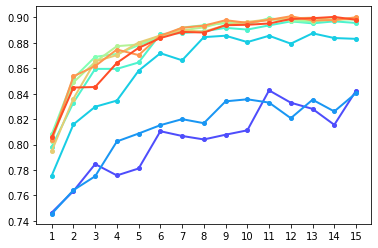

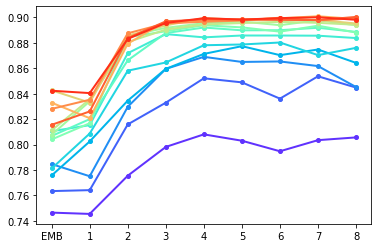

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

nsteps, nlayers = avg_test_mccs.shape

palette = sns.color_palette('rainbow', nlayers)
for i, mcc_scores in enumerate(avg_test_mccs.T):
    plt.plot(mcc_scores, 'o-', lw=2, markersize=4, c=palette[i])

plt.xticks(range(nsteps), range(1, 16))
plt.show()


palette = sns.color_palette('rainbow', nsteps)
for i, mcc_scores in enumerate(avg_test_mccs):
    plt.plot(mcc_scores, 'o-', lw=2, markersize=4, c=palette[i])

plt.xticks(range(9), ['EMB'] + list(range(1,9)))
plt.show()

In [48]:
avg_test_mccs.T.shape

(9, 15)

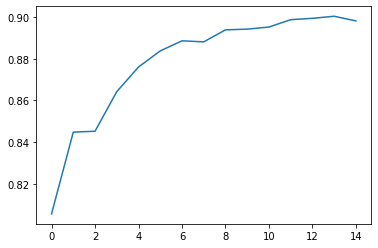

In [63]:
plt.plot([x[-1] for x in avg_test_mccs])

[0.8823703258918006, 0.9014411188526527, 0.9376175323596094, 0.9445925518599212, 0.94719496514984, 0.9494584379108576, 0.9506574101897919, 0.9479544709761611, 0.9468234453477086]
[0.8578028819555645, 0.8724834352014822, 0.9014811524401188, 0.910205959165561, 0.9125877879657339, 0.9179532876358504, 0.9163553077284855, 0.9139123096888796, 0.9122711066554737]


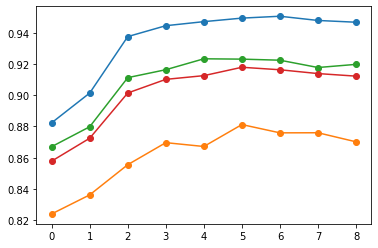

In [148]:
import matplotlib.pyplot as plt

prev_mccs = [0.8239673901301782, 0.8361725071462424, 0.8555170017152565, 0.8696371475065608, 0.8671830405557985, 0.8812323481371813, 0.8759250345310242, 0.875984161791563, 0.8701755100790699]
prev_mccs2 = [0.8670709298447149, 0.8798366796055512, 0.9113089232454907, 0.916388178130201, 0.9233853581915631, 0.9231690768595123, 0.9224834784646403, 0.9177982962989147, 0.9198143645396428]
prev_mccs3 = [0.8823703258918006, 0.9014411188526527, 0.9376175323596094, 0.9445925518599212, 0.94719496514984, 0.9494584379108576, 0.9506574101897919, 0.9479544709761611, 0.9468234453477086]

print(test_mccs)

plt.plot(test_mccs, 'o-')
plt.plot(prev_mccs, 'o-')
plt.plot(prev_mccs2, 'o-')
plt.plot(np.mean(np.array([test_mccs, prev_mccs, prev_mccs2]), axis=0), 'o-')

print(list(np.mean(np.array([test_mccs, prev_mccs, prev_mccs2]), axis=0)))

In [100]:
span_label_vocab

{'PRN': 0,
 'VP': 1,
 'SBAR': 2,
 'S': 3,
 'UCP': 4,
 'NP': 5,
 'ADVP': 6,
 'SBARQ': 7,
 'PP': 8,
 'QP': 9,
 'FRAG': 10,
 'INTJ': 11,
 'ADJP': 12,
 'RRC': 13,
 'PRT': 14,
 'NAC': 15,
 'CONJP': 16,
 'SINV': 17,
 'SQ': 18}

In [111]:
sorted(Counter(test_preds[0]).items())

[(0, 866),
 (1, 3330),
 (2, 4),
 (3, 219),
 (4, 9),
 (5, 3710),
 (6, 10),
 (7, 9),
 (8, 13),
 (9, 4),
 (10, 149),
 (11, 12),
 (12, 2234),
 (13, 5),
 (14, 99)]

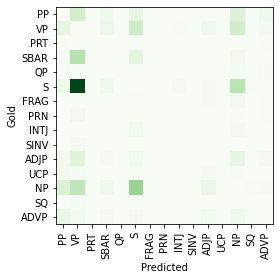

In [137]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(4,4))
cmatrix = confusion_matrix(*test_preds)
np.fill_diagonal(cmatrix, 0)

plt.imshow(cmatrix, cmap="Greens")
plt.xticks(range(len(span_label_vocab)), span_label_vocab.keys(), rotation=90)
plt.yticks(range(len(span_label_vocab)), span_label_vocab.keys())
plt.xlabel('Predicted')
plt.ylabel('Gold')
plt.show()